<a href="https://colab.research.google.com/github/mianshariq/Datasets/blob/main/Data624_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import numpy as np
import pandas as pd
import IPython.display as display
from matplotlib import pyplot as plt
import io
import seaborn as sns
import statsmodels.api as sm
import itertools


In [104]:
df_atm=pd.read_csv('https://github.com/mianshariq/Datasets/raw/d51be14393c37f74b1692f75fd04acc34fa8cb2b/ATM624Data.csv')
df_pwr=pd.read_csv('https://github.com/mianshariq/Datasets/raw/d51be14393c37f74b1692f75fd04acc34fa8cb2b/ResidentialCustomerForecastLoad-624.csv')
df_wp1=pd.read_csv('https://github.com/mianshariq/Datasets/raw/d51be14393c37f74b1692f75fd04acc34fa8cb2b/Waterflow_Pipe1.csv')
df_wp2=pd.read_csv('https://github.com/mianshariq/Datasets/raw/d51be14393c37f74b1692f75fd04acc34fa8cb2b/Waterflow_Pipe2.csv')

In [62]:
df_wp1

Date Time  WaterFlow
0    10/23/15 12:24 AM  23.369599
1    10/23/15 12:40 AM  28.002881
2    10/23/15 12:53 AM  23.065895
3    10/23/15 12:55 AM  29.972809
4     10/23/15 1:19 AM   5.997953
..                 ...        ...
995   11/1/15 10:09 PM  26.336684
996   11/1/15 10:25 PM  29.064266
997   11/1/15 11:08 PM  22.844104
998   11/1/15 11:34 PM  16.218705
999   11/1/15 11:35 PM  21.211707

[1000 rows x 2 columns]

## Part A
I want you to forecast how much cash is taken out of 4 different ATM machines for May 2010.  The data is given in a single file.  The variable ‘Cash’ is provided in hundreds of dollars, other than that it is straight forward.   I am being somewhat ambiguous on purpose to make this have a little more business feeling.  Explain and demonstrate your process, techniques used and not used, and your actual forecast.  I am giving you data via an excel file, please provide your written report on your findings, visuals, discussion and your R code via an RPubs link along with the actual.rmd file  Also please submit the forecast which you will put in an Excel readable file.


### EDA

In [63]:
df_atm['DATE'] = pd.to_datetime(df_atm['DATE']).dt.date
df_atm.dtypes


DATE     object
ATM      object
Cash    float64
dtype: object

The first thing would be to look at the data on an overall level and to see any intresting details to dig deeper into.
Some of the thing we may want to look into.
1- Counts are not equal distributed which may indicate null vales.
2- The standard diviation for ATM 3 and 4 is higher than the mean, this could mean there are outliers but will need to take a look.
3- Median for ATM 3 is 0 which needs to be furthered iunvestegated.

In [64]:
df_atm.groupby('ATM').describe()

Cash                                                           
      count        mean         std  min    25%    50%    75%      max
ATM                                                                   
ATM1  362.0   83.886740   36.656539  1.0   73.0   91.0  108.0    180.0
ATM2  363.0   62.578512   38.898455  0.0   25.5   67.0   93.0    147.0
ATM3  365.0    0.720548    7.944778  0.0    0.0    0.0    0.0     96.0
ATM4  365.0  474.013699  650.946962  2.0  124.0  404.0  705.0  10920.0

Missing data is very crucail in Time Series, we cant just drop the row. So we will look at the missing data.
On the ATM column, there are 14 missing values. and on the cash side there 19 missing values.
However there ar dates, and we can look at the rows which are missing

In [65]:
null_counts = df_atm.isnull().sum()
print(null_counts)

DATE     0
ATM     14
Cash    19
dtype: int64


In [66]:
grouped_null_counts = df_atm.groupby('ATM').apply(lambda x: x.isnull().sum())
grouped_null_counts

DATE  ATM  Cash
ATM                  
ATM1     0    0     3
ATM2     0    0     2
ATM3     0    0     0
ATM4     0    0     0

In [68]:
print(df_atm.groupby('ATM')['DATE'].min())
print(df_atm.groupby('ATM')['DATE'].max())
df_atm=df_atm.dropna(subset=['ATM'])
df_atm[df_atm.isnull().any(axis=1)]

ATM
ATM1    2009-05-01
ATM2    2009-05-01
ATM3    2009-05-01
ATM4    2009-05-01
Name: DATE, dtype: object
ATM
ATM1    2010-04-30
ATM2    2010-04-30
ATM3    2010-04-30
ATM4    2010-04-30
Name: DATE, dtype: object


DATE   ATM  Cash
86   2009-06-13  ATM1   NaN
92   2009-06-16  ATM1   NaN
97   2009-06-18  ATM2   NaN
104  2009-06-22  ATM1   NaN
109  2009-06-24  ATM2   NaN

Now that we have rermoved the extra dates, we can look at imputing the missing values, but before we look at that, letts look for any outlies.


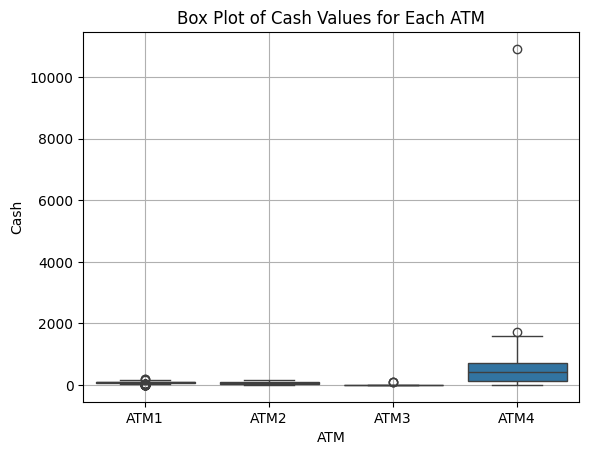

In [69]:
sns.boxplot(data=df_atm, x='ATM', y='Cash')
plt.title('Box Plot of Cash Values for Each ATM')
plt.xlabel('ATM')
plt.ylabel('Cash')
plt.grid(True)
plt.show()


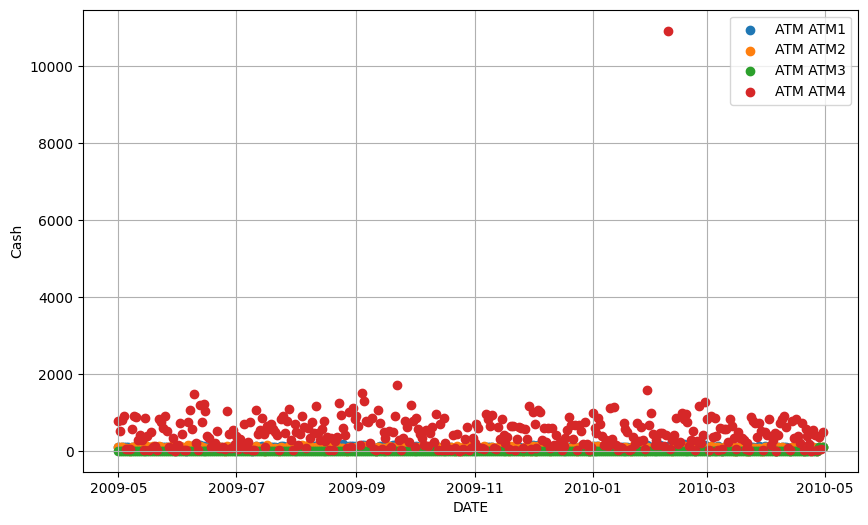

In [70]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

for atm, data in df_atm.groupby('ATM'):
    ax.scatter(data['DATE'], data['Cash'], label=f'ATM {atm}')

# Add labels and legend
ax.set_xlabel('DATE')
ax.set_ylabel('Cash')
ax.legend()

# Show the plot
plt.grid(True)
plt.show()


We cannot drop the Outlier, so instead we will make it as mean of ATM 4.

In [71]:
df_atm['DATE'] = pd.to_datetime(df_atm['DATE'])
df_atm.loc[df_atm['Cash'] > 10000, 'Cash'] = np.nan
df_atm[df_atm['DATE'] =="2010-02-09"]


DATE   ATM   Cash
568  2010-02-09  ATM1  123.0
569  2010-02-09  ATM2   45.0
1028 2010-02-09  ATM3    0.0
1393 2010-02-09  ATM4    NaN

In [72]:
df_atm.groupby('ATM').describe()

Cash                                                            
      count        mean         std  min     25%    50%     75%     max
ATM                                                                    
ATM1  362.0   83.886740   36.656539  1.0   73.00   91.0  108.00   180.0
ATM2  363.0   62.578512   38.898455  0.0   25.50   67.0   93.00   147.0
ATM3  365.0    0.720548    7.944778  0.0    0.00    0.0    0.00    96.0
ATM4  364.0  445.315934  351.384600  2.0  123.75  403.5  704.25  1712.0

In [73]:
group_means = df_atm.groupby('ATM')['Cash'].mean()

# Step 3: Replace the null values with the calculated means for each group
for atm, mean in group_means.items():
    df_atm.loc[(df_atm['ATM'] == atm) & df_atm['Cash'].isnull(), 'Cash'] = mean


In [74]:
df_atm[df_atm['DATE'] =='2010-02-09']

DATE   ATM        Cash
568  2010-02-09  ATM1  123.000000
569  2010-02-09  ATM2   45.000000
1028 2010-02-09  ATM3    0.000000
1393 2010-02-09  ATM4  445.315934

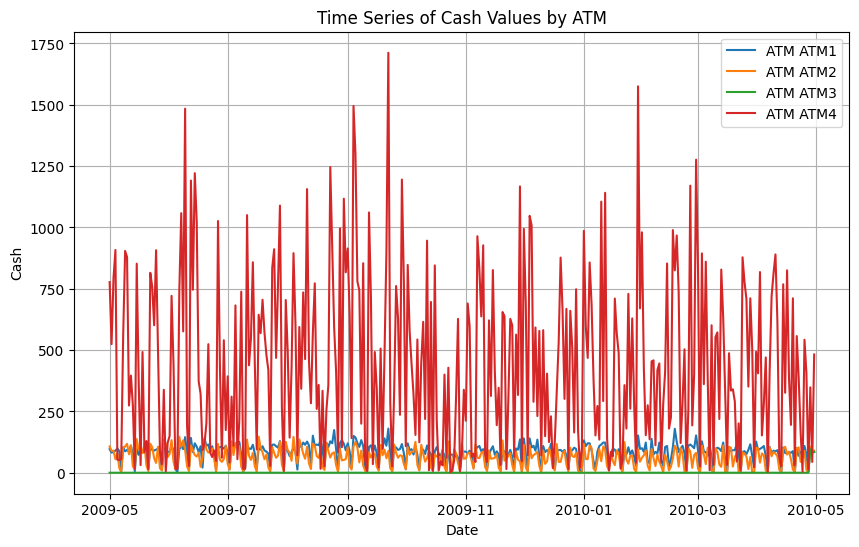

In [75]:
# Group the DataFrame by 'ATM'
grouped = df_atm.groupby('ATM')

# Plot time series lines for each ATM
plt.figure(figsize=(10, 6))
for atm, group_data in grouped:
    plt.plot(group_data['DATE'], group_data['Cash'], label=f'ATM {atm}')

plt.title('Time Series of Cash Values by ATM')
plt.xlabel('Date')
plt.ylabel('Cash')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
df_atm1=df_atm[df_atm['ATM']=='ATM1']
df_atm2=df_atm[df_atm['ATM']=='ATM2']
df_atm3=df_atm[df_atm['ATM']=='ATM3']
df_atm4=df_atm[df_atm['ATM']=='ATM4']

## SDT

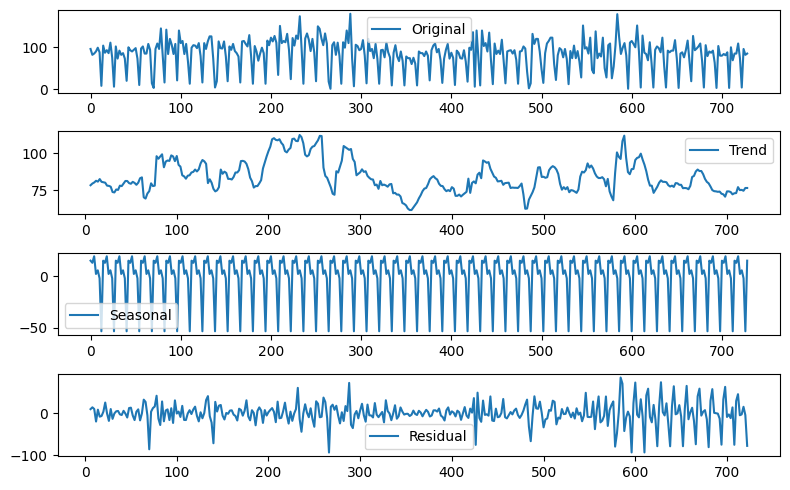

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

frequency = 12  # For example, if data is monthly, set frequency to 12

decomposition = seasonal_decompose(df_atm1['Cash'], model='additive', period=7)
decomposition

plt.figure(figsize=(8, 5))

plt.subplot(411)
plt.plot(df_atm1['Cash'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

In [78]:
df_atm1

DATE   ATM  Cash
0   2009-05-01  ATM1  96.0
2   2009-05-02  ATM1  82.0
4   2009-05-03  ATM1  85.0
6   2009-05-04  ATM1  90.0
8   2009-05-05  ATM1  99.0
..         ...   ...   ...
720 2010-04-26  ATM1  74.0
722 2010-04-27  ATM1   4.0
724 2010-04-28  ATM1  96.0
726 2010-04-29  ATM1  82.0
728 2010-04-30  ATM1  85.0

[365 rows x 3 columns]

<ipython-input-79-ff6cd586e321>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atm1['Lag_7'] = df_atm1['Cash'].shift(7)


Fold 1 MAE: 9.00


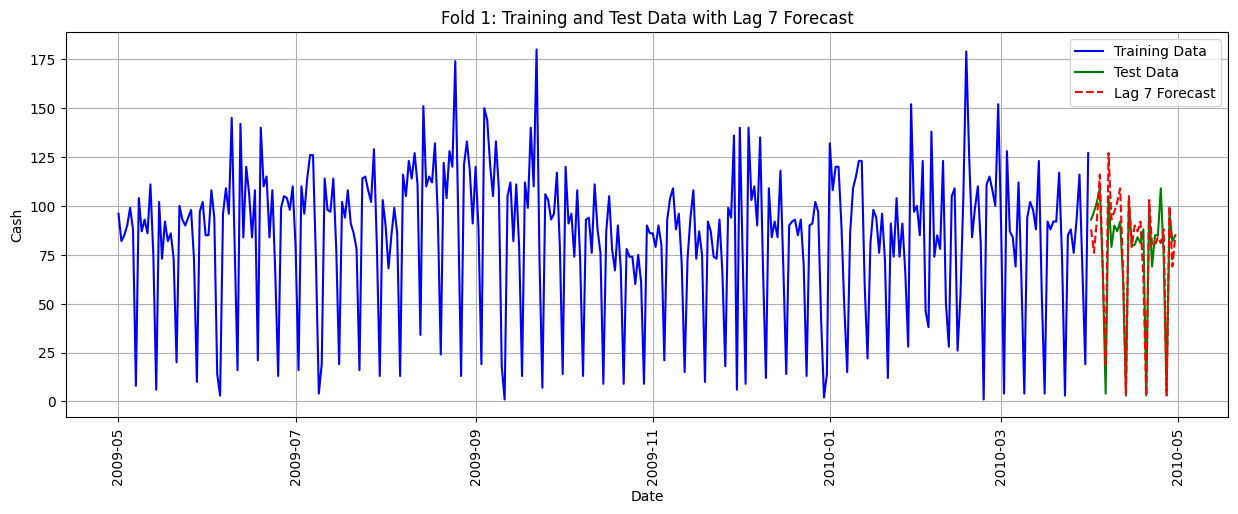



Fold 2 MAE: 13.67


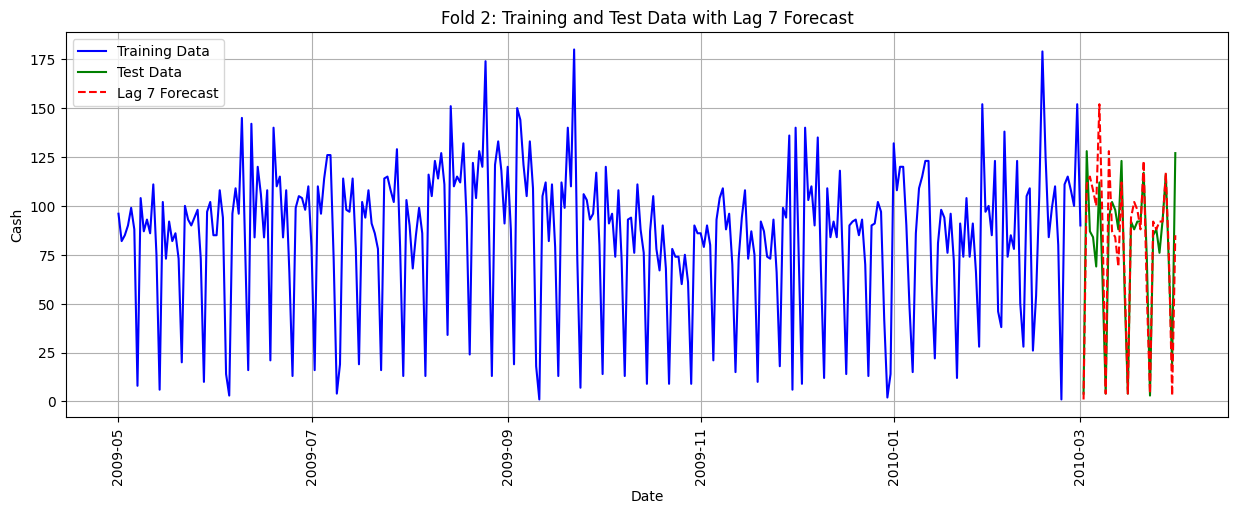



Fold 3 MAE: 31.50


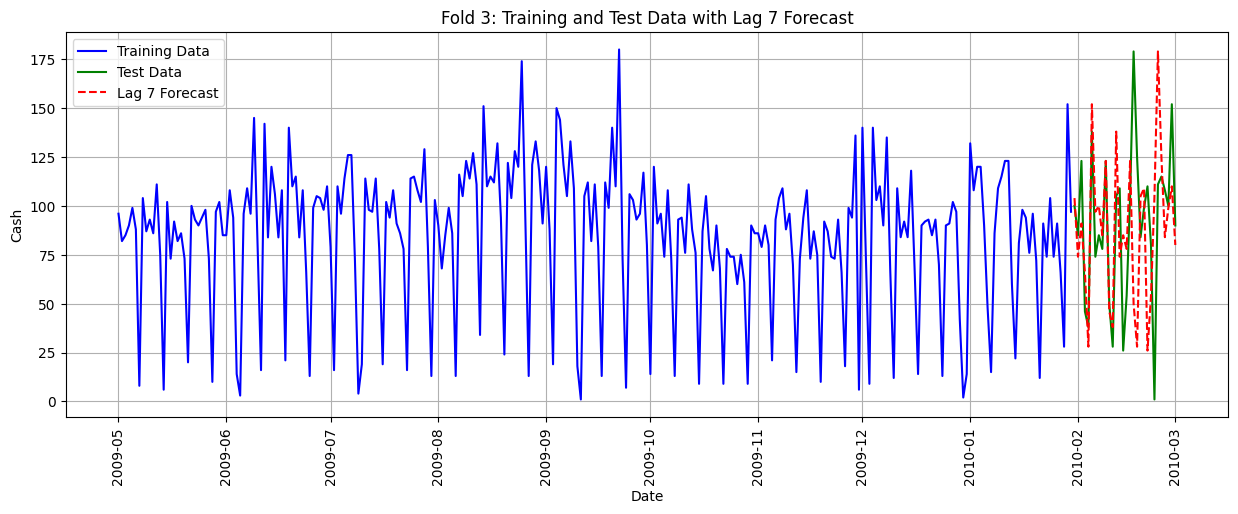



Fold 4 MAE: 19.73


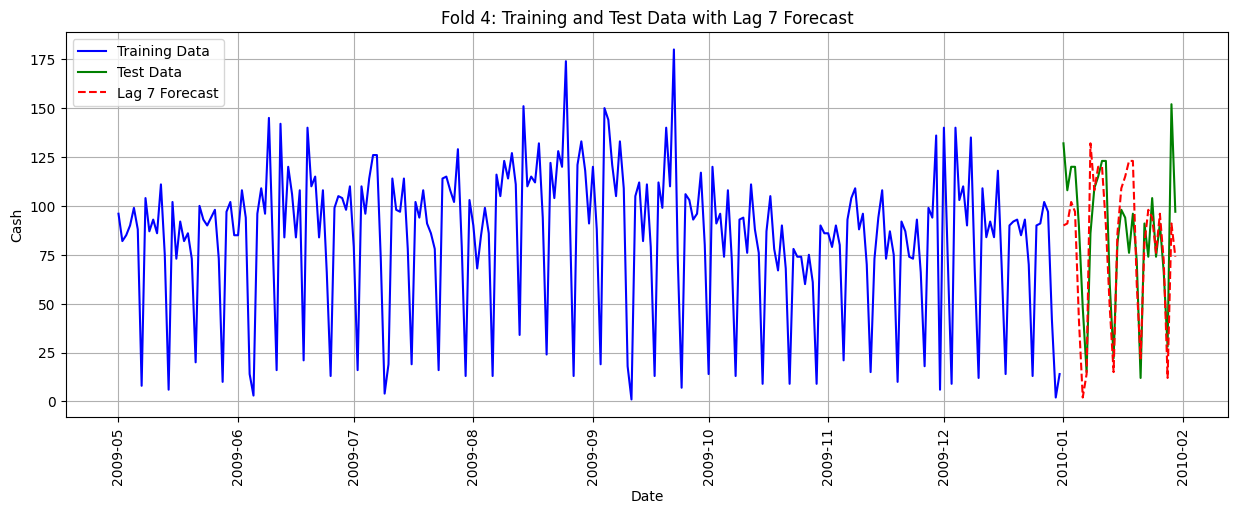



Fold 5 MAE: 16.10


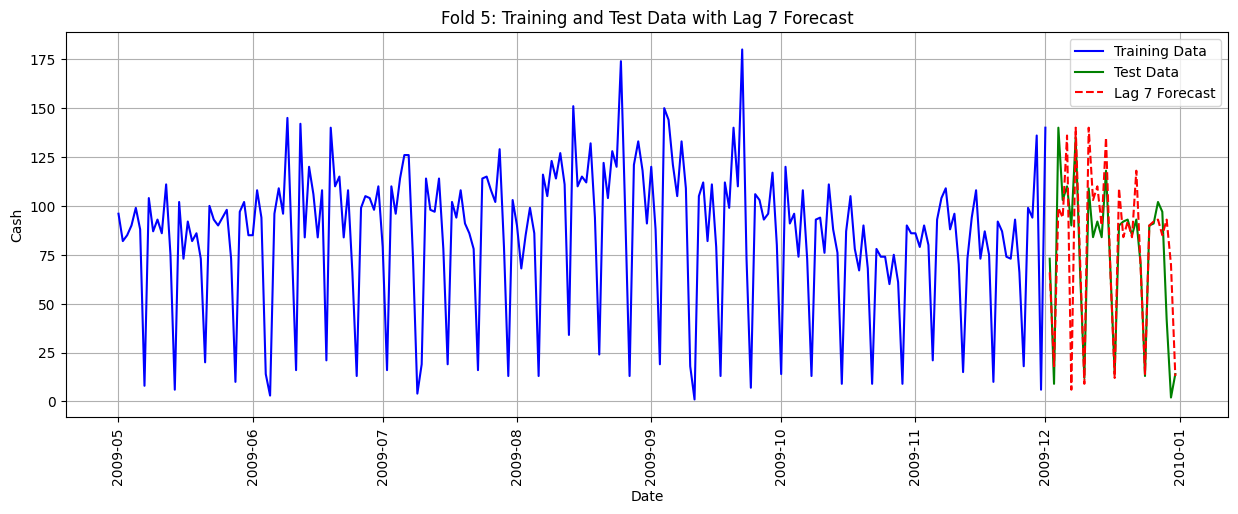



Fold 6 MAE: 15.93


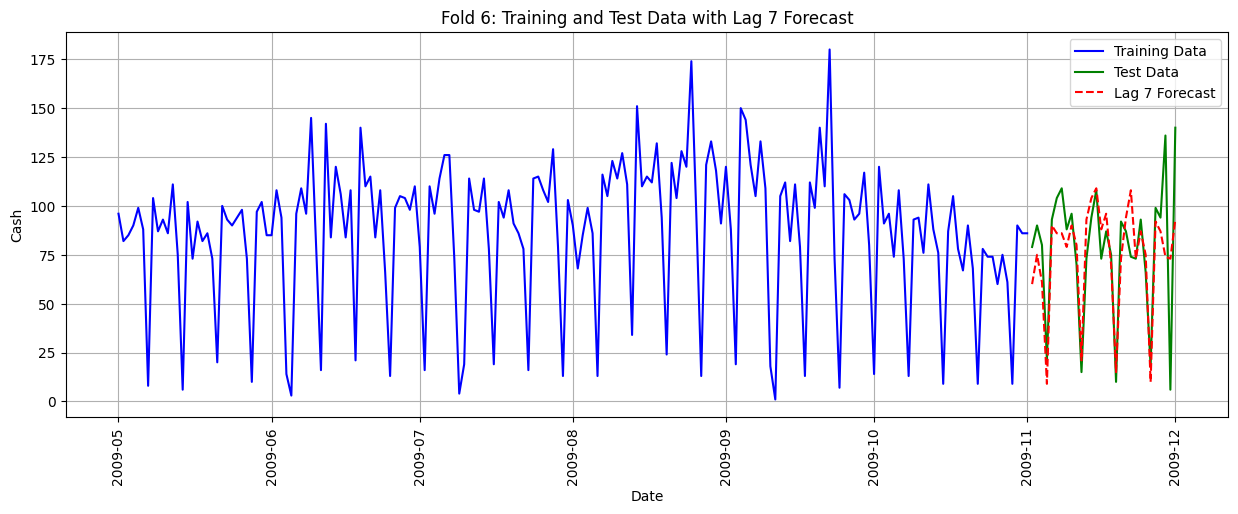



Fold 7 MAE: 11.67


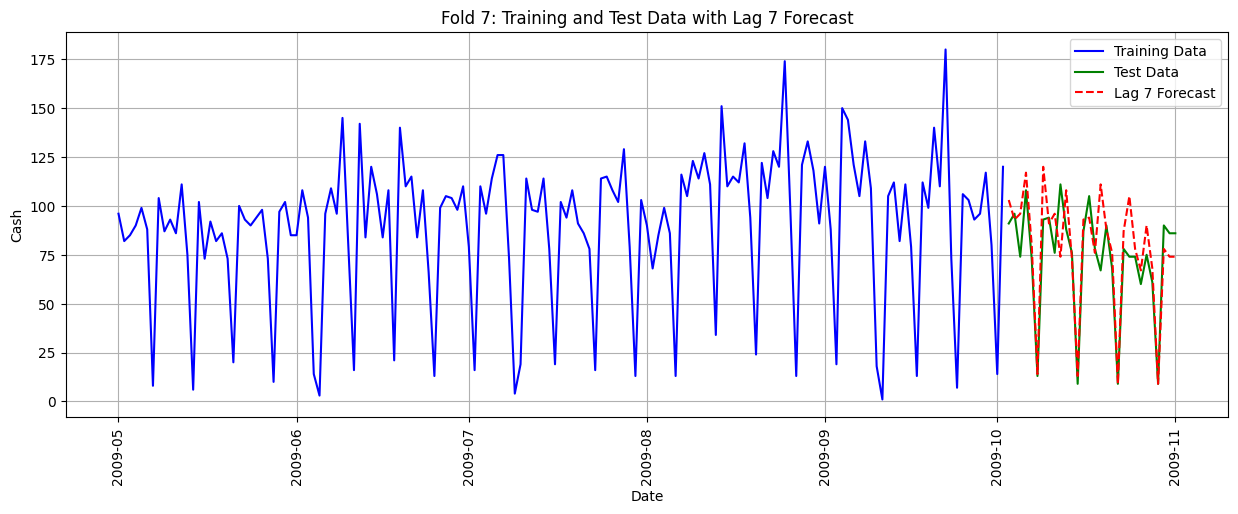



Fold 8 MAE: 26.37


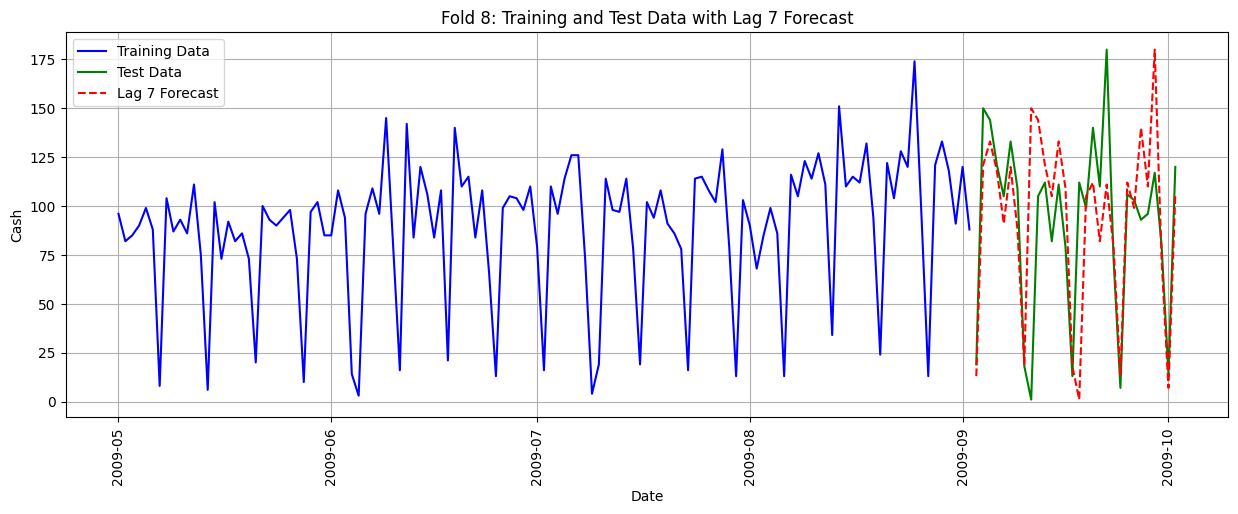



Total Average MAE: 18.00


In [79]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data stored in a DataFrame named 'data'
# Replace this with your actual data loading process
df_atm1['Lag_7'] = df_atm1['Cash'].shift(7)
# Number of days for training and testing
n_train_days = len(df_atm1) - 30  # Training data excludes the last 30 days
n_test_days = 30

# List to store the generated DataFrames
dfs = []

# Loop to create eight DataFrames
for i in range(8):
    # Extract training and testing data
    train_data = df_atm1.iloc[:n_train_days]
    test_data = df_atm1.iloc[n_train_days:n_train_days + n_test_days]

    # Append the current fold to the list of DataFrames
    dfs.append((train_data, test_data))

    # Update n_train_days for the next fold
    n_train_days -= n_test_days



# Initialize total MAE
total_mae = 0

for i, (train_data, test_data) in enumerate(dfs, 1):
    # Calculate MAE
    mae = mean_absolute_error(test_data['Cash'], test_data['Lag_7'])

    # Add current fold MAE to total MAE
    total_mae += mae

    # Output results with two decimal places
    print(f"Fold {i} MAE: {mae:.2f}")

    # Plot training data
    plt.figure(figsize=(15, 5))
    plt.plot(train_data['DATE'], train_data['Cash'], label='Training Data', color='blue')

    # Plot test data
    plt.plot(test_data['DATE'], test_data['Cash'], label='Test Data', color='green')

    # Plot lagged values (forecast) in the test data
    plt.plot(test_data['DATE'], test_data['Lag_7'], label='Lag 7 Forecast', linestyle='--', color='red')

    plt.xlabel('Date')
    plt.ylabel('Cash')
    plt.title(f'Fold {i}: Training and Test Data with Lag 7 Forecast')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
    print("\n" + "="*40 + "\n")

# Calculate average MAE
average_mae = total_mae / len(dfs)

# Output total average MAE with two decimal places
print(f"Total Average MAE: {average_mae:.2f}")

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

def split_data(df, n_train_days, n_test_days):
    """
    Split the data into training and testing sets.

    Args:
    - df: DataFrame containing the data
    - n_train_days: Number of days for training
    - n_test_days: Number of days for testing

    Returns:
    - List of tuples, each containing training and testing DataFrames
    """
    dfs = []
    for i in range(8):
        train_data = df.iloc[:n_train_days]
        test_data = df.iloc[n_train_days:n_train_days + n_test_days]
        dfs.append((train_data, test_data))
        n_train_days -= n_test_days -23
    return dfs

def calculate_mae(predictions, actual):
    """
    Calculate the mean absolute error (MAE).

    Args:
    - predictions: Array of predicted values
    - actual: Array of actual values

    Returns:
    - MAE
    """
    return mean_absolute_error(actual, predictions)

def plot_actual_vs_predicted(train_data, test_data, predictions, fold_num):
    """
    Plot the actual vs predicted values.

    Args:
    - train_data: DataFrame containing training data
    - test_data: DataFrame containing testing data
    - predictions: Array of predicted values
    - fold_num: Fold number
    """
    plt.figure(figsize=(15, 5))
    plt.plot(train_data['DATE'], train_data['Cash'], label='Training Data', color='blue')
    plt.plot(test_data['DATE'], test_data['Cash'], label='Test Data', color='green')
    plt.plot(test_data['DATE'], predictions, label='Predictions', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Cash')
    plt.title(f'Fold {fold_num}: Actual vs Predicted')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_mae_and_plot(dfs, forecast_function):
    """
    Calculate MAE for each fold and plot actual vs predicted values.

    Args:
    - dfs: List of tuples, each containing training and testing DataFrames
    - forecast_function: Function to generate predictions

    Returns:
    - Total average MAE
    """
    total_mae = 0

    for i, (train_data, test_data) in enumerate(dfs, 1):
        predictions = forecast_function(train_data, test_data)
        mae = calculate_mae(predictions, test_data['Cash'])
        total_mae += mae
        print(f"Fold {i} MAE: {mae:.2f}")
        plot_actual_vs_predicted(train_data, test_data, predictions, i)
        print("\n" + "="*40 + "\n")

    average_mae = total_mae / len(dfs)
    print(f"Total Average MAE: {average_mae:.2f}")


In [81]:
def exponential_smoothing_forecast(train, test, alpha=0.2):

    # Initialize predictions with the last observed value from training data
    predictions = [train['Cash'].iloc[-1]]

    # Apply exponential smoothing for each observation in the test data
    for i in range(len(test)):
        next_pred = alpha * test['Cash'].iloc[i] + (1 - alpha) * predictions[-1]
        predictions.append(next_pred)

    return predictions[1:]  # Exclude the initial value used for initialization


Fold 1 MAE: 19.74


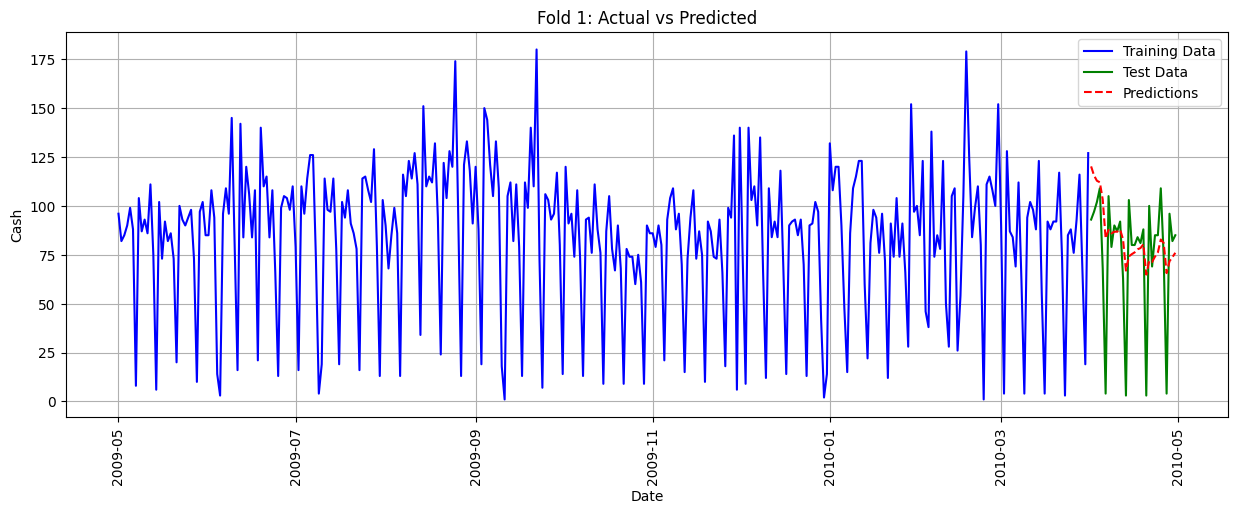



Fold 2 MAE: 19.32


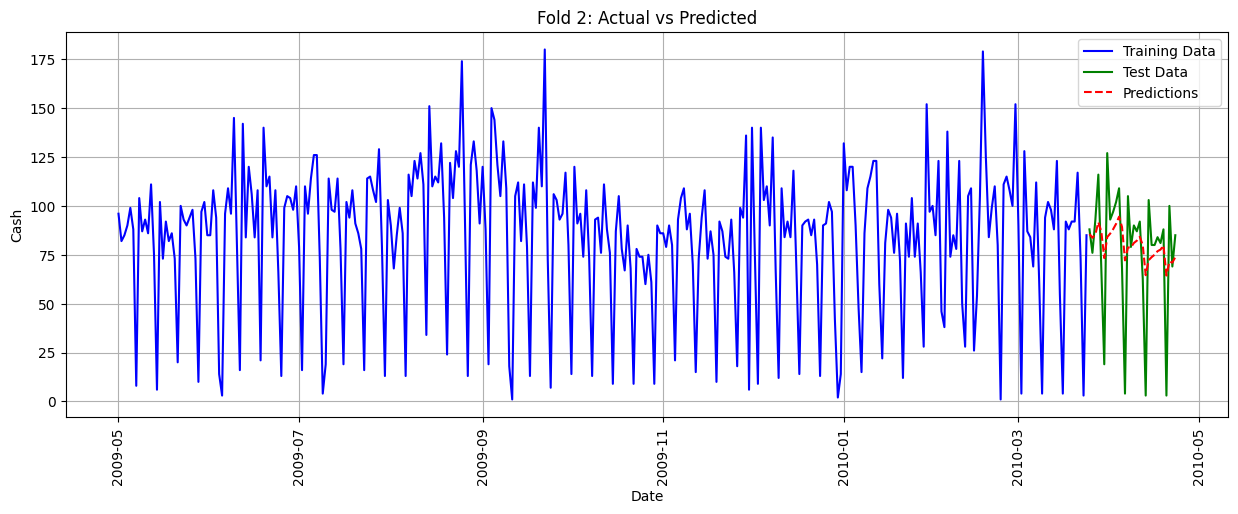



Fold 3 MAE: 19.72


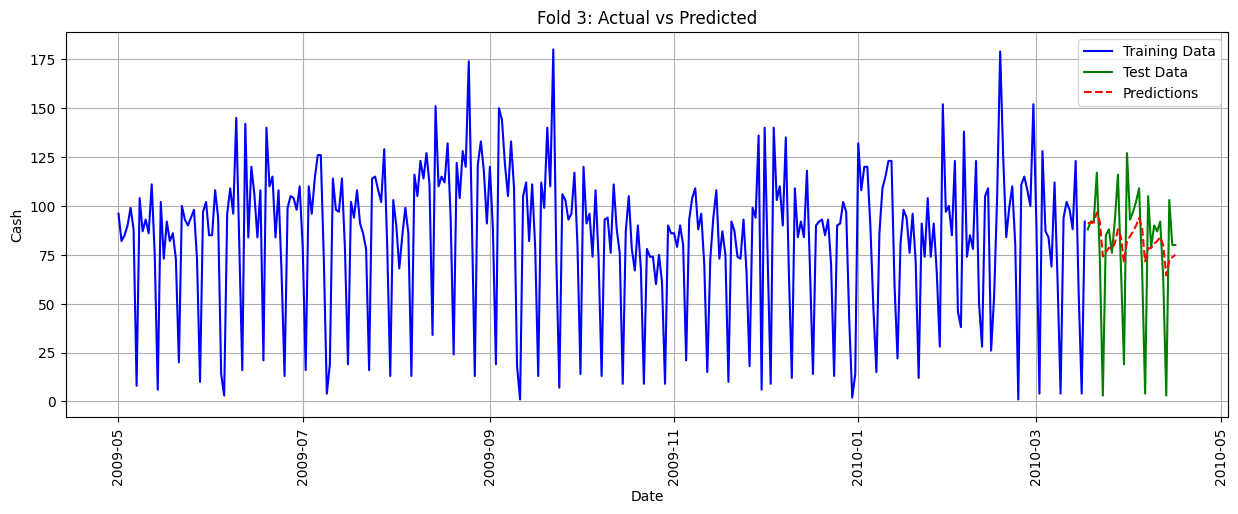



Fold 4 MAE: 21.42


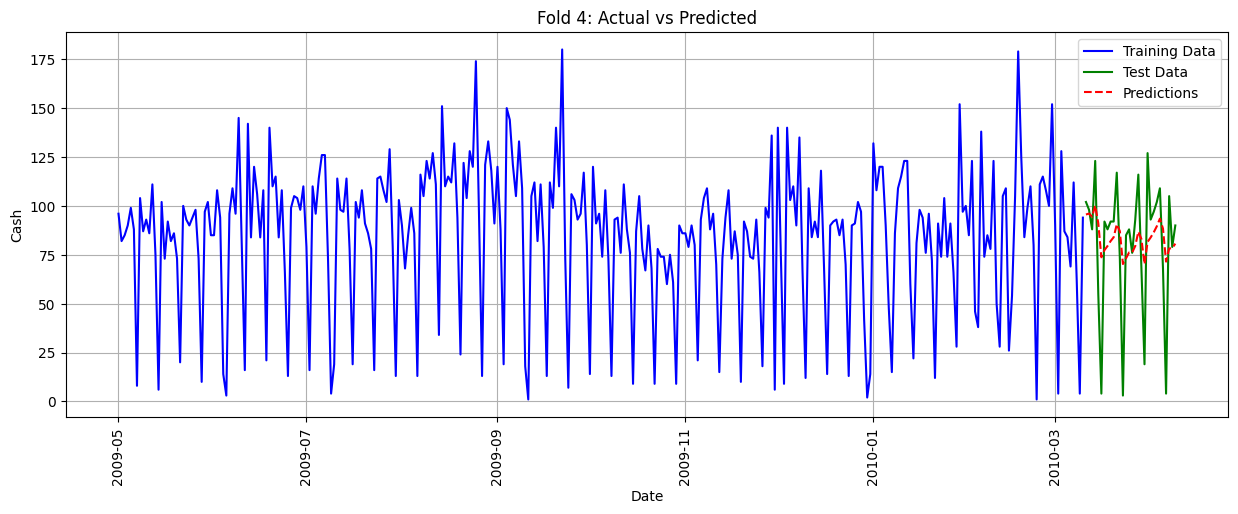



Fold 5 MAE: 24.43


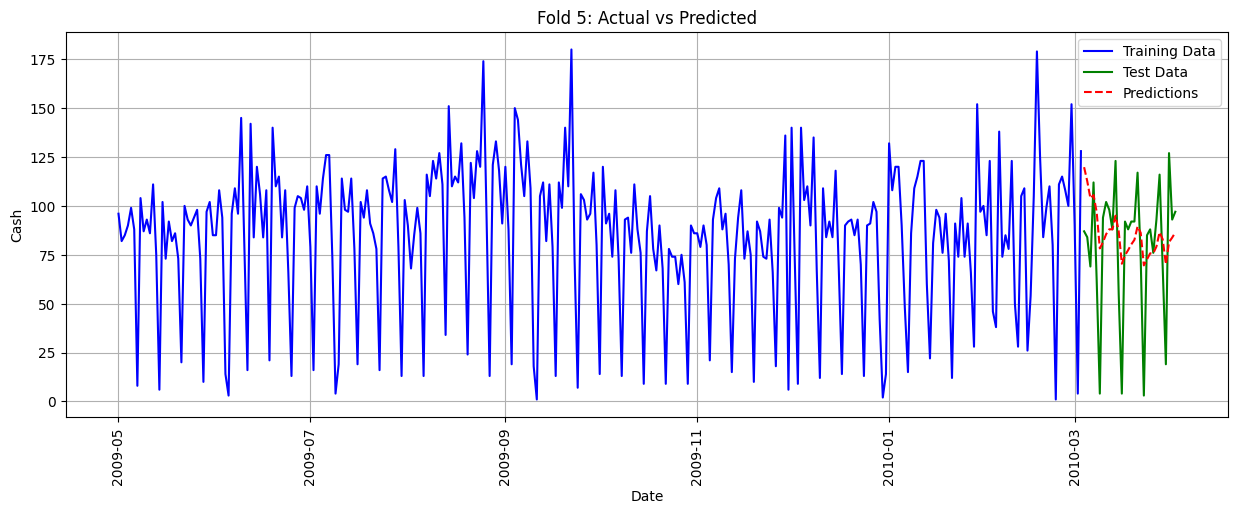



Fold 6 MAE: 23.47


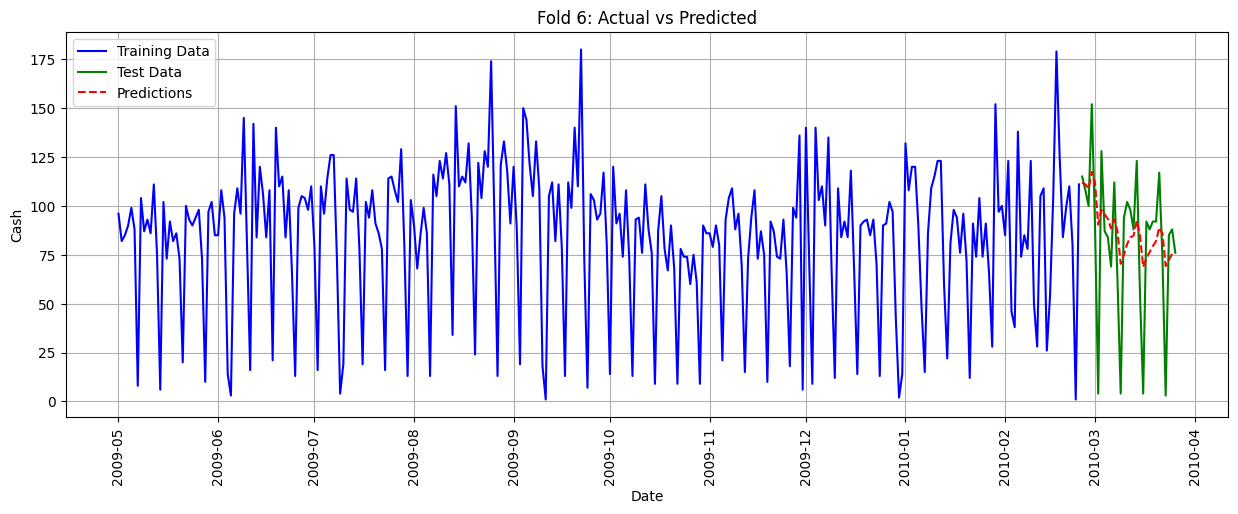



Fold 7 MAE: 29.67


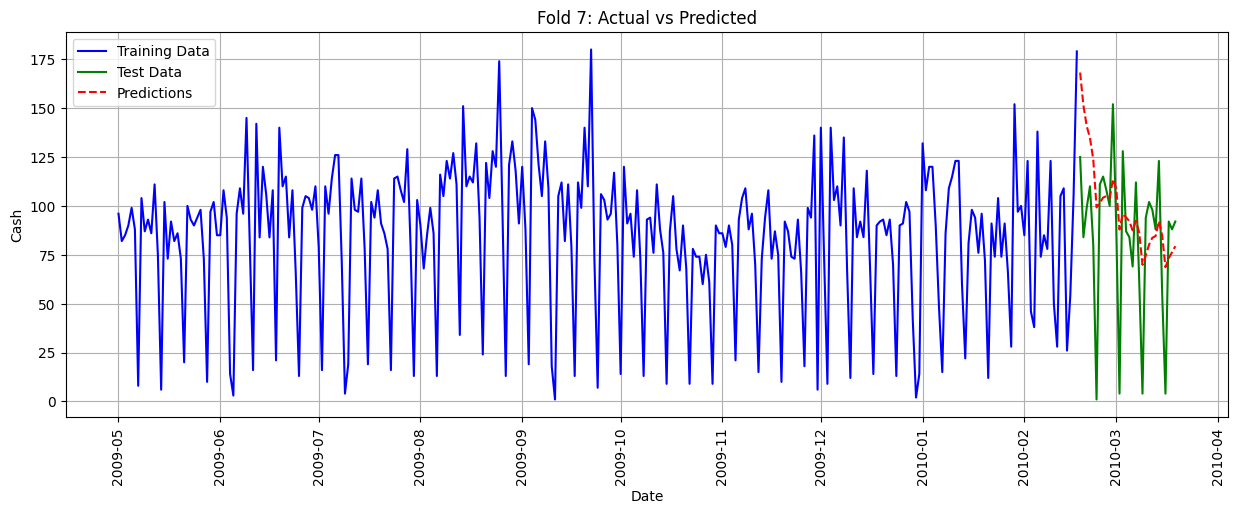



Fold 8 MAE: 28.49


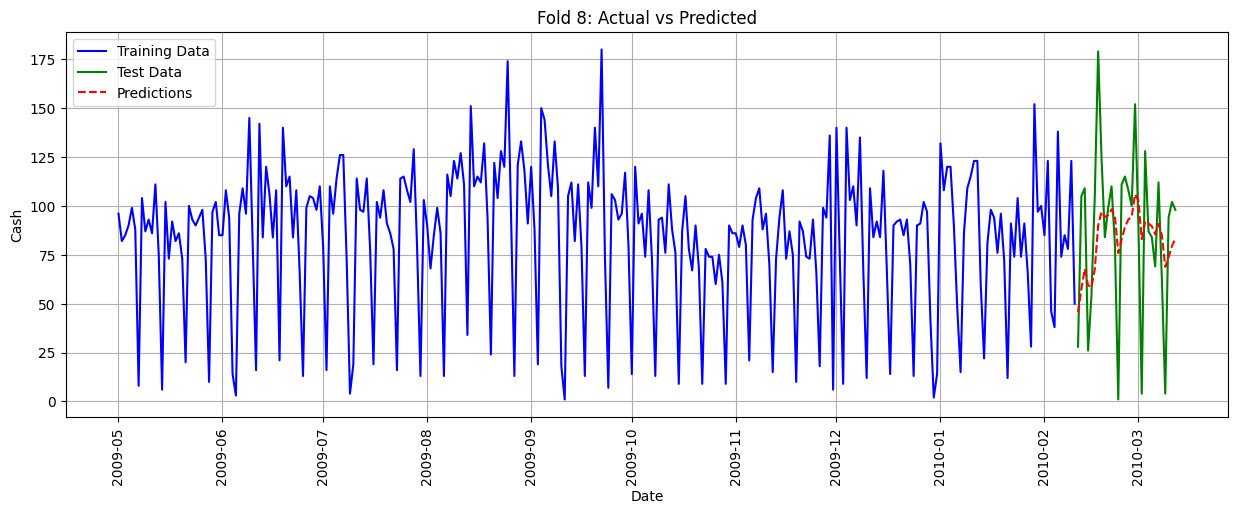



Total Average MAE: 23.28


In [82]:
n_train_days = len(df_atm1) - 30
n_test_days = 30

dfs = split_data(df_atm1, n_train_days, n_test_days)
calculate_mae_and_plot(dfs, exponential_smoothing_forecast)

In [83]:
df_atm1

DATE   ATM  Cash  Lag_7
0   2009-05-01  ATM1  96.0    NaN
2   2009-05-02  ATM1  82.0    NaN
4   2009-05-03  ATM1  85.0    NaN
6   2009-05-04  ATM1  90.0    NaN
8   2009-05-05  ATM1  99.0    NaN
..         ...   ...   ...    ...
720 2010-04-26  ATM1  74.0   88.0
722 2010-04-27  ATM1   4.0    3.0
724 2010-04-28  ATM1  96.0  100.0
726 2010-04-29  ATM1  82.0   69.0
728 2010-04-30  ATM1  85.0   85.0

[365 rows x 4 columns]

In [84]:
df_atm_ses=df_atm1

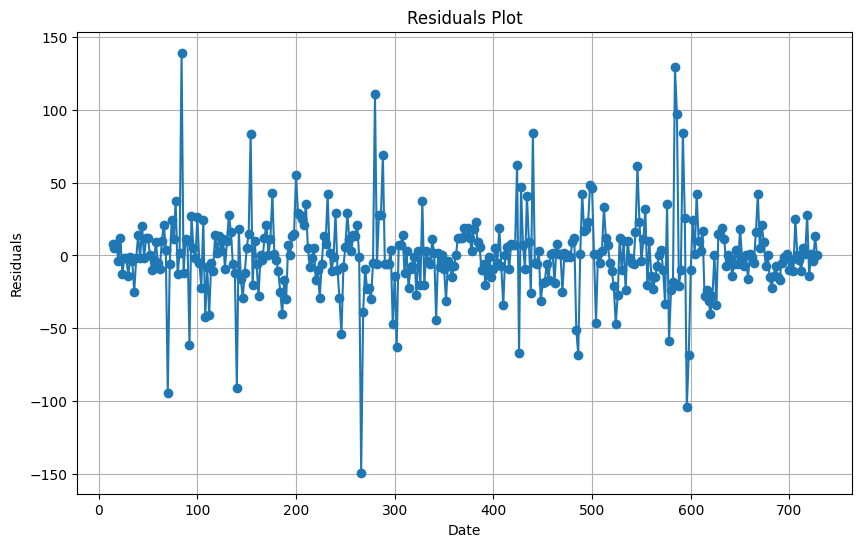

In [85]:
residuals = df_atm1['Cash'] - df_atm1['Lag_7']
plt.figure(figsize=(10, 6))
plt.plot(df_atm1.index, residuals, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


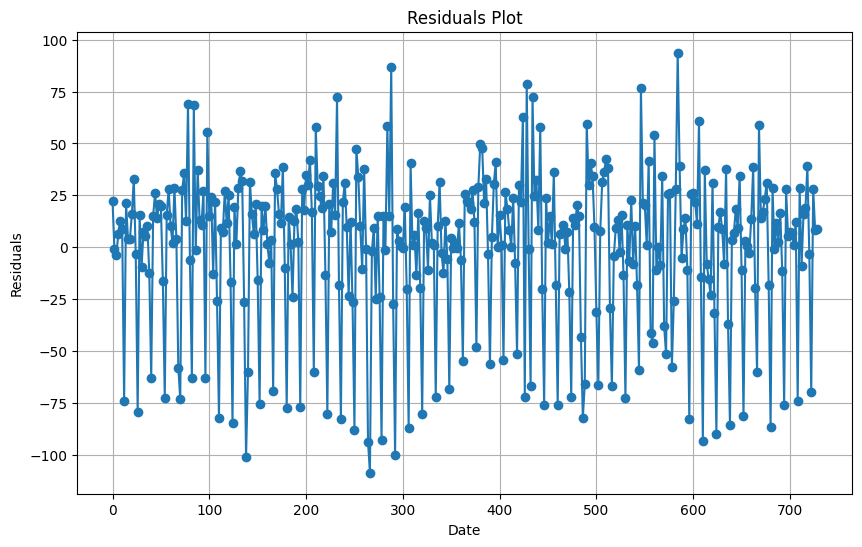

In [86]:
# Fit Holt-Winters Exponential Smoothing model with manual initialization
model_holt_winters = sm.tsa.ExponentialSmoothing(df_atm_ses['Cash'], trend='add', seasonal='add', seasonal_periods=12)
results = model_holt_winters.fit()
residuals = df_atm1['Cash'] - results.fittedvalues
plt.figure(figsize=(10, 6))
plt.plot(df_atm1.index, residuals, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

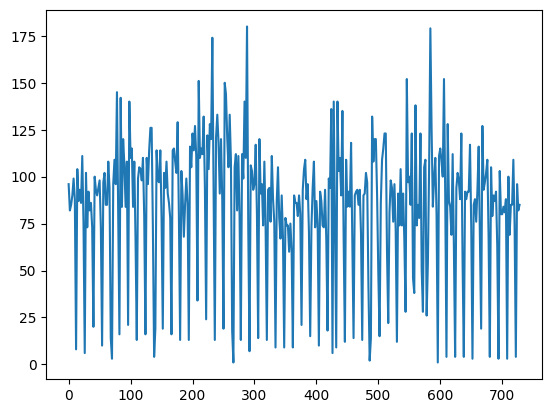

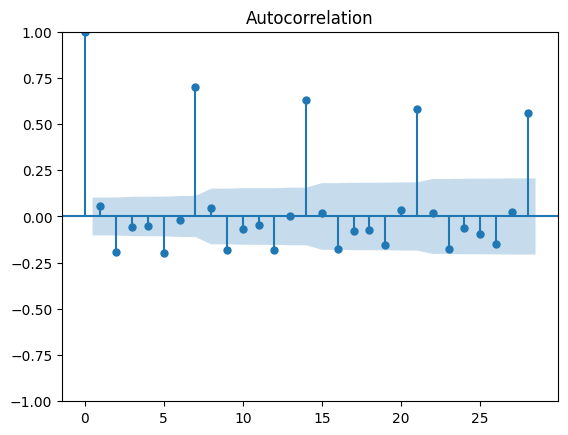

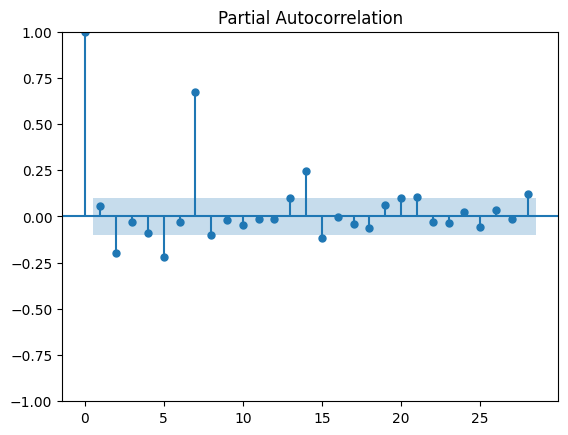

In [87]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.plot(df_atm1['Cash'])
# Plot ACF and PACF
plot_acf(df_atm1['Cash'], lags=28)
plt.show()

plot_pacf(df_atm1['Cash'], lags=28)
plt.show()


The ACF graph shows weekly seasonality, with large spikes in lags 7, 14 and 21 , and the Spectrum plot shows the frequencies 1, 2, 3. This is suggestive of seasonal ARIMA model.being a significant lag. The ACF seems to be decreasing relatively slowly which could be an indicator that the data is non-stationary and could potentially benefit from differencing.

In [88]:
#pip install pmdarima

In [89]:
from pmdarima.arima.utils import ndiffs

n_diffs = ndiffs(df_atm1['Cash'])

print("Number of differences needed:", n_diffs)


Number of differences needed: 0


No differencing is required.

In [90]:
import itertools

def ARIMA_eval_aic(params):
    p, d, q = params
    try:
        model = ARIMA(df_atm1['Cash'], order=(p, d, q))
        results = model.fit()
        return results.aic
    except:
        return None

# Define the ranges for p, d, and q
p_range = range(0, 3)
d_range = range(0, 3)
q_range = range(0, 3)

# Generate all possible combinations of p, d, and q
param_grid = itertools.product(p_range, d_range, q_range)

# Filter out combinations where p, d, and q are not all greater than 0
param_grid_filtered = [(p, d, q) for (p, d, q) in param_grid if (p > 0 or d > 0 or q > 0)]

# Calculate AIC for each combination
aic_values = {}
for params in param_grid_filtered:
    aic_values[params] = ARIMA_eval_aic(params)

# Print all AIC values
for params, aic in aic_values.items():
    print(f"({params}): AIC = {aic}")


((0, 0, 1)): AIC = None
((0, 0, 2)): AIC = None
((0, 1, 0)): AIC = None
((0, 1, 1)): AIC = None
((0, 1, 2)): AIC = None
((0, 2, 0)): AIC = None
((0, 2, 1)): AIC = None
((0, 2, 2)): AIC = None
((1, 0, 0)): AIC = None
((1, 0, 1)): AIC = None
((1, 0, 2)): AIC = None
((1, 1, 0)): AIC = None
((1, 1, 1)): AIC = None
((1, 1, 2)): AIC = None
((1, 2, 0)): AIC = None
((1, 2, 1)): AIC = None
((1, 2, 2)): AIC = None
((2, 0, 0)): AIC = None
((2, 0, 1)): AIC = None
((2, 0, 2)): AIC = None
((2, 1, 0)): AIC = None
((2, 1, 1)): AIC = None
((2, 1, 2)): AIC = None
((2, 2, 0)): AIC = None
((2, 2, 1)): AIC = None
((2, 2, 2)): AIC = None


In [91]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit ARIMA model
model_arima = ARIMA(df_atm1['Cash'], order=(1, 0, 1), seasonal_order=(0, 0, 0, 7))


results = model_arima.fit()

# Get the residuals of the fitted ARIMA model
residuals = results.resid

sm.stats.acorr_ljungbox(residuals, lags=[7], return_df=True)





/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


lb_stat     lb_pvalue
7  177.330685  7.132109e-35

In [92]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Cash   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1820.476
Date:                Mon, 25 Mar 2024   AIC                           3648.953
Time:                        02:27:30   BIC                           3664.553
Sample:                             0   HQIC                          3655.152
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.8882      2.419     34.682      0.000      79.147      88.629
ar.L1         -0.7309      0.087     -8.416      0.000      -0.901      -0.561
ma.L1          0.8931      0.055     16.240      0.000       0.785       1.001
sigma2      1257.2187     96.418     13.039      0.000    1068.242    1446.195
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 8.23
Prob(Q):                              0.34   Prob(JB):                         0.02
Heteroskedasticity (H):               0.99   Skew:                            -0.37
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the context of the Ljung-Box test, The p-value represents the probability of observing the test statistic (or more extreme) under the null hypothesis. In this case, a very small p-value like 7.13 e-35 indicates strong evidence against the null hypothesis, suggesting that the data are not random or exhibit some form of autocorrelation up to the specified lag.

In [93]:
df_atm1.reset_index(drop=True, inplace=True)
df_atm1

DATE   ATM  Cash  Lag_7
0   2009-05-01  ATM1  96.0    NaN
1   2009-05-02  ATM1  82.0    NaN
2   2009-05-03  ATM1  85.0    NaN
3   2009-05-04  ATM1  90.0    NaN
4   2009-05-05  ATM1  99.0    NaN
..         ...   ...   ...    ...
360 2010-04-26  ATM1  74.0   88.0
361 2010-04-27  ATM1   4.0    3.0
362 2010-04-28  ATM1  96.0  100.0
363 2010-04-29  ATM1  82.0   69.0
364 2010-04-30  ATM1  85.0   85.0

[365 rows x 4 columns]

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error


def split_data(df, n_train_days, n_test_days):
    dfs = []
    for i in range(8):
        train_data = df.iloc[:n_train_days]
        test_data = df.iloc[n_train_days:n_train_days + n_test_days]
        dfs.append((train_data, test_data))
        n_train_days -= n_test_days
    return dfs

def calculate_mae(predictions, actual):
    return mean_absolute_error(actual, predictions)

def plot_actual_vs_predicted(train_data, test_data, predictions, fold_num):
    plt.figure(figsize=(15, 5))
    plt.plot(train_data['DATE'], train_data['Cash'], label='Training Data', color='blue')
    plt.plot(test_data['DATE'], test_data['Cash'], label='Test Data', color='green')
    plt.plot(test_data['DATE'], predictions, label='Predictions', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Cash')
    plt.title(f'Fold {fold_num}: Actual vs Predicted')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_mae_and_plot(dfs, forecast_function):
    total_mae = 0

    for i, (train_data, test_data) in enumerate(dfs, 1):
        predictions = forecast_function(train_data, test_data)
        mae = calculate_mae(predictions, test_data['Cash'])
        total_mae += mae
        print(f"Fold {i} MAE: {mae:.2f}")
        plot_actual_vs_predicted(train_data, test_data, predictions, i)
        print("\n" + "="*40 + "\n")

    average_mae = total_mae / len(dfs)
    print(f"Total Average MAE: {average_mae:.2f}")


Fold 1 MAE: 9.36


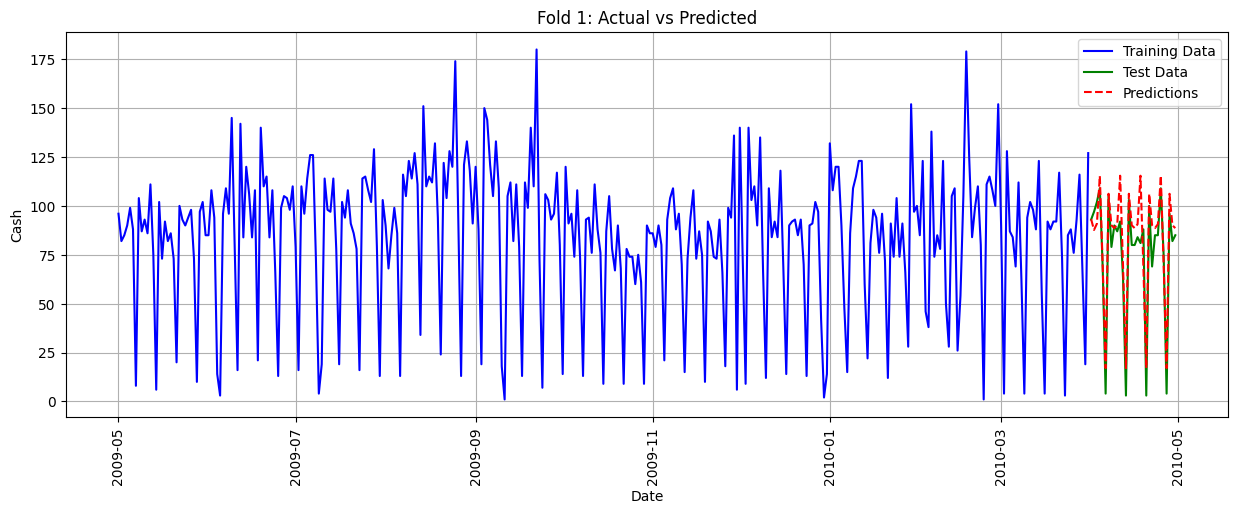



Fold 2 MAE: 32.64


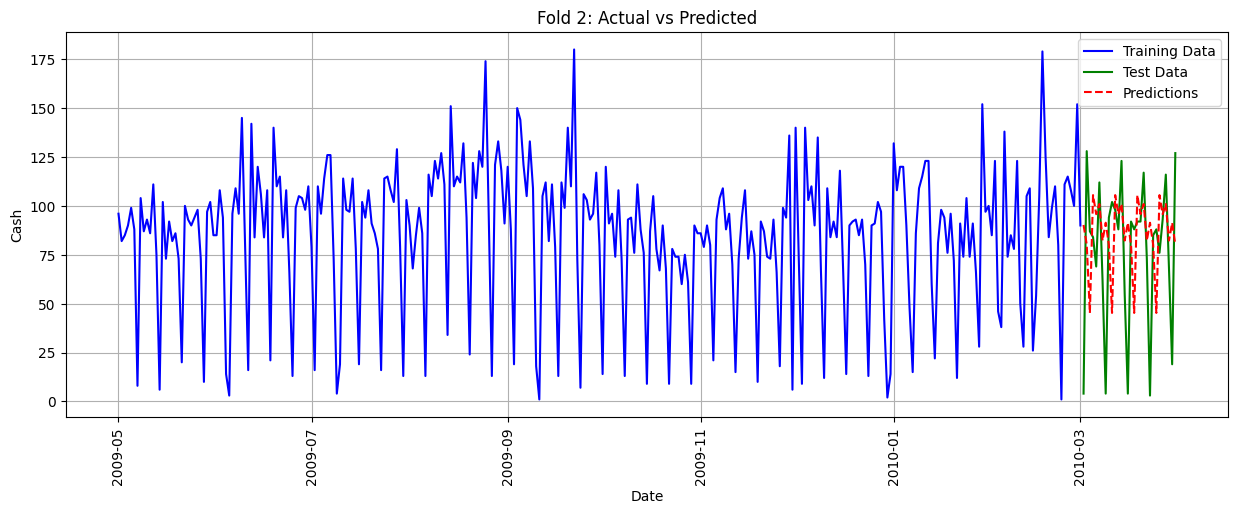



Fold 3 MAE: 29.94


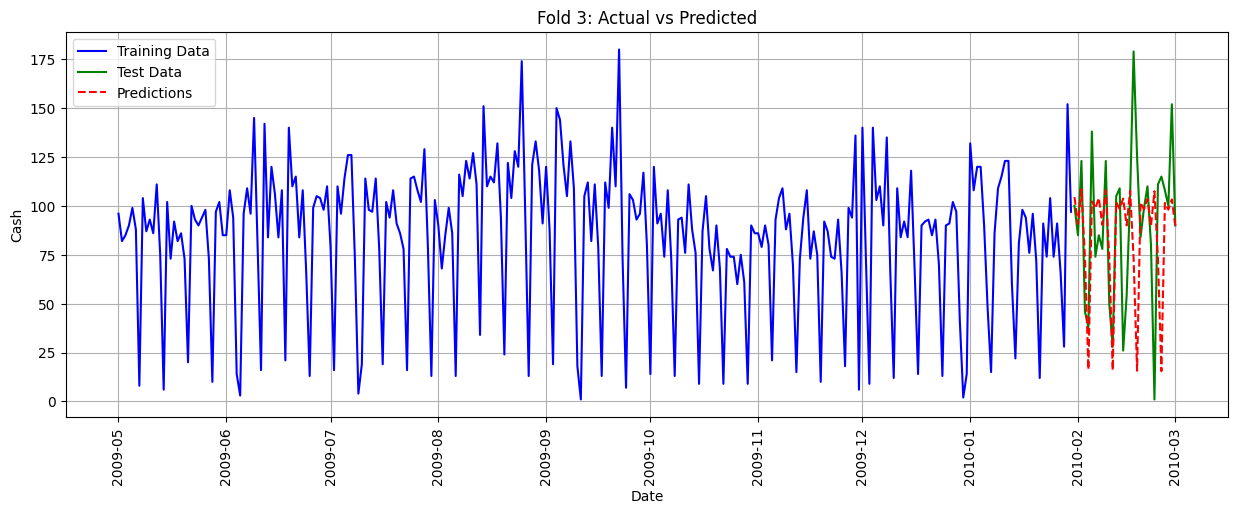

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 4 MAE: 16.89


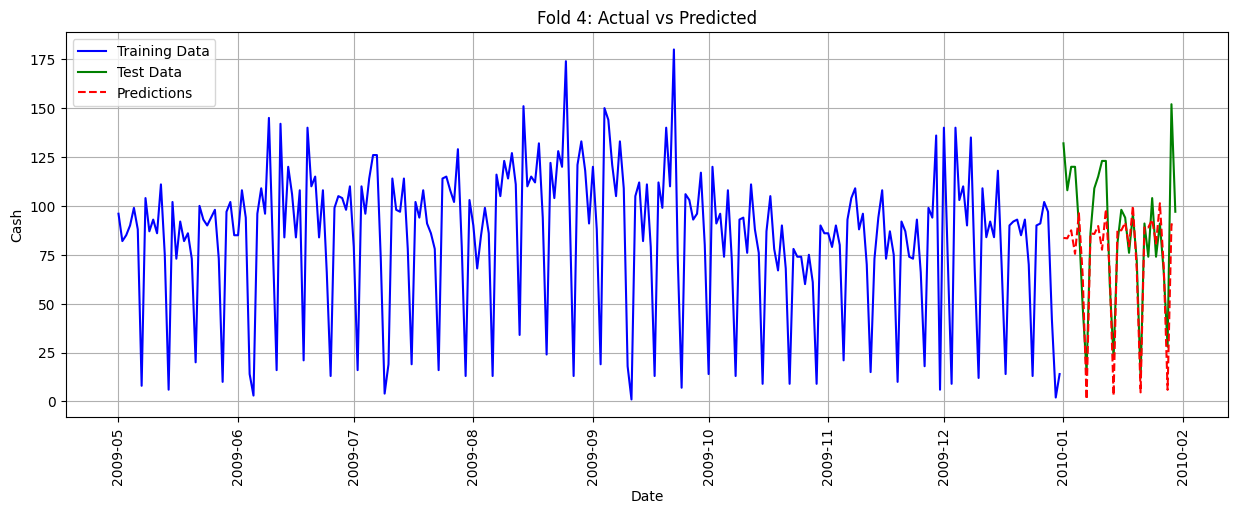



Fold 5 MAE: 12.59


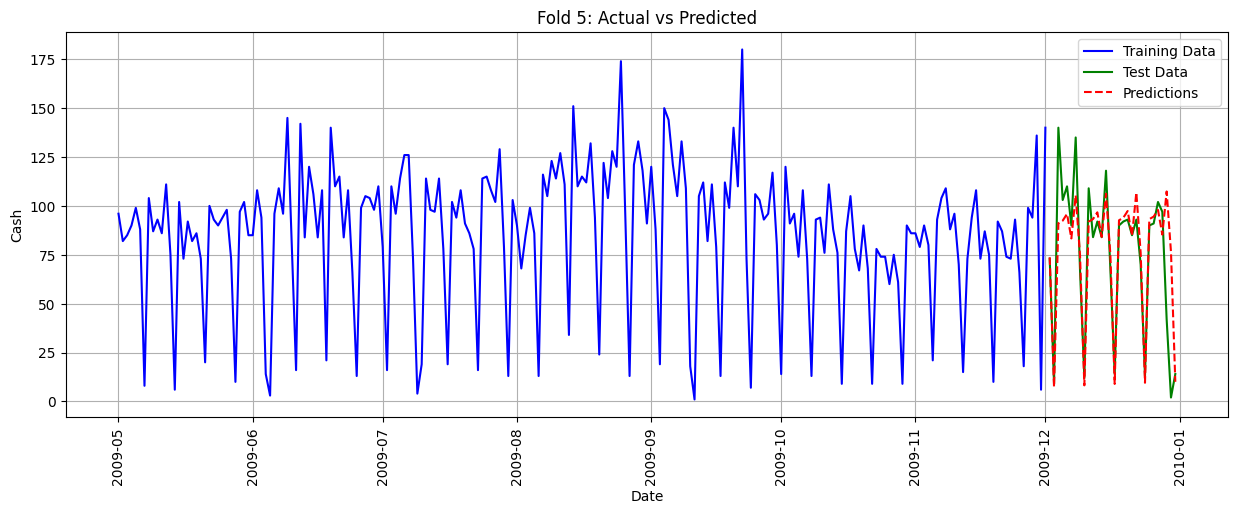



Fold 6 MAE: 14.03


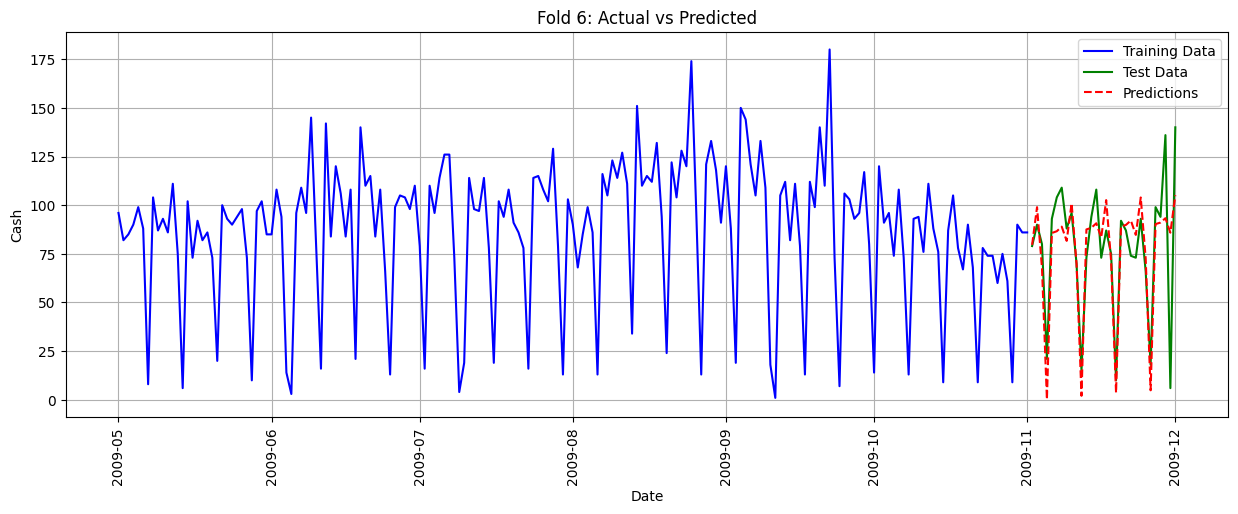



Fold 7 MAE: 19.08


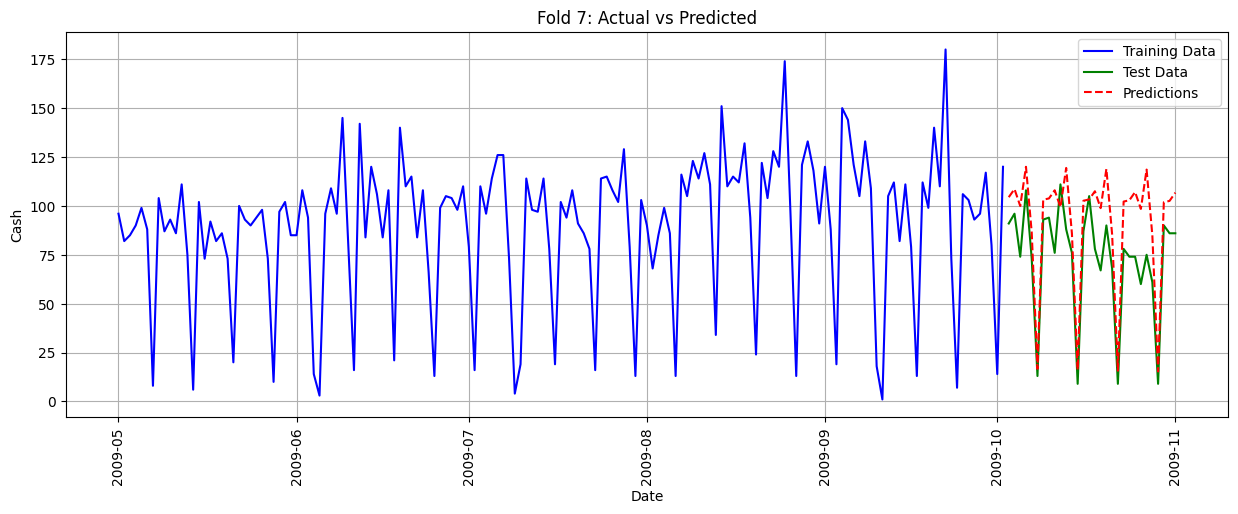

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fold 8 MAE: 18.67


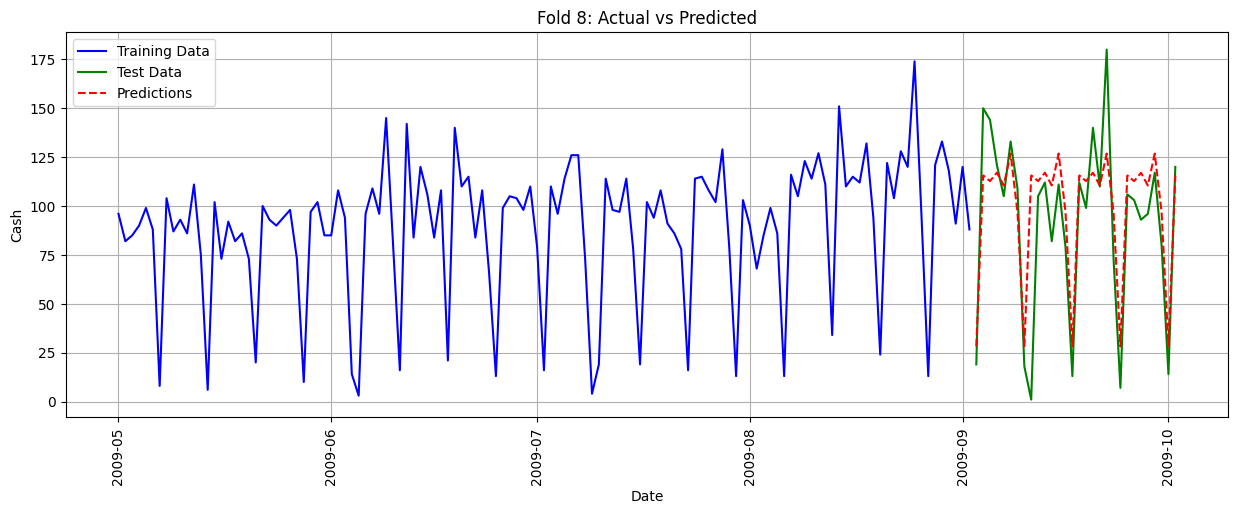



Total Average MAE: 19.15


In [95]:
def arima_forecast(train_data, test_data):
    # Fit ARIMA model
    model = ARIMA(train_data['Cash'], order=(1, 0, 1), seasonal_order=(0, 1, 1, 7))  # You may need to adjust the order
    model_fit = model.fit()

    # Make predictions
    forecast = model_fit.forecast(steps=len(test_data))

    return forecast

n_train_days = len(df_atm1) - 30
n_test_days = 30

dfs = split_data(df_atm1, n_train_days, n_test_days)
calculate_mae_and_plot(dfs, arima_forecast)


Fold 1 MAE: 10.33


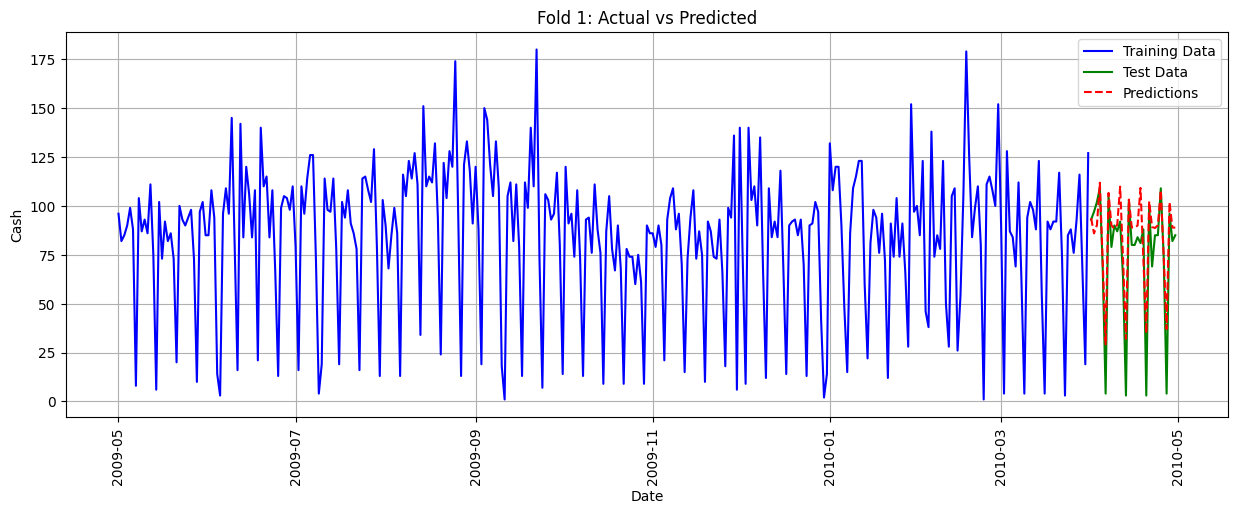



Fold 2 MAE: 18.70


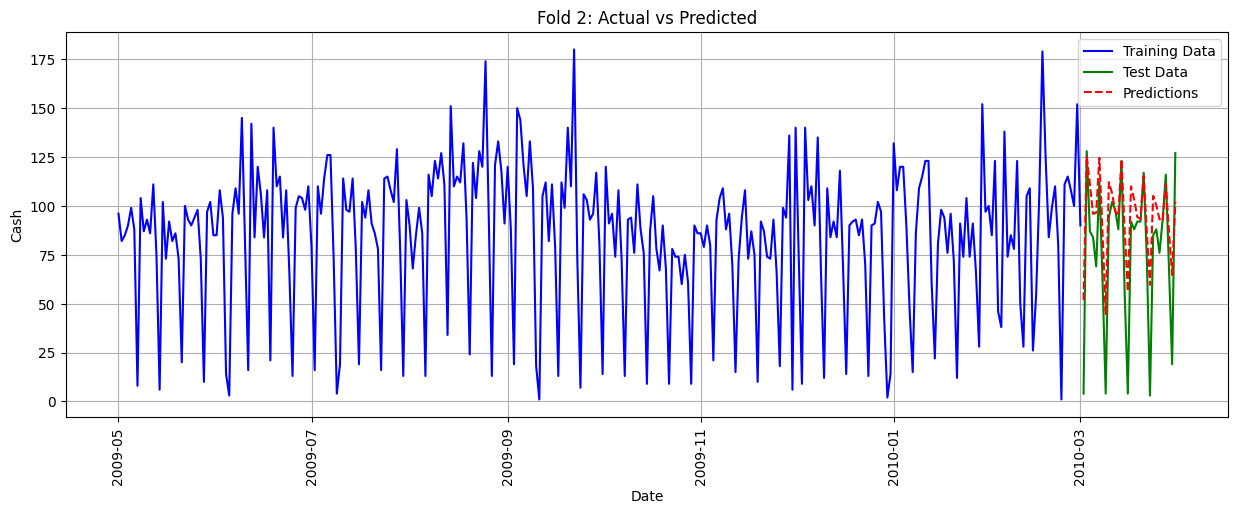



Fold 3 MAE: 28.54


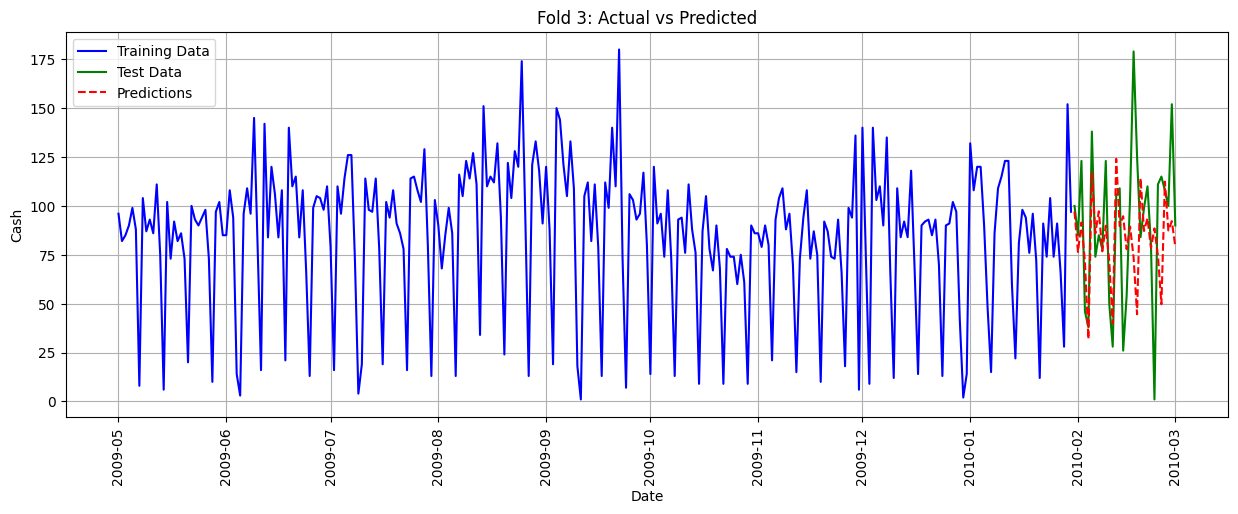

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(4,1,1)(2,0,0)[7]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/usr/local/lib/python3.10/dist-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "/usr/local/lib/python3.

Fold 4 MAE: 63.47


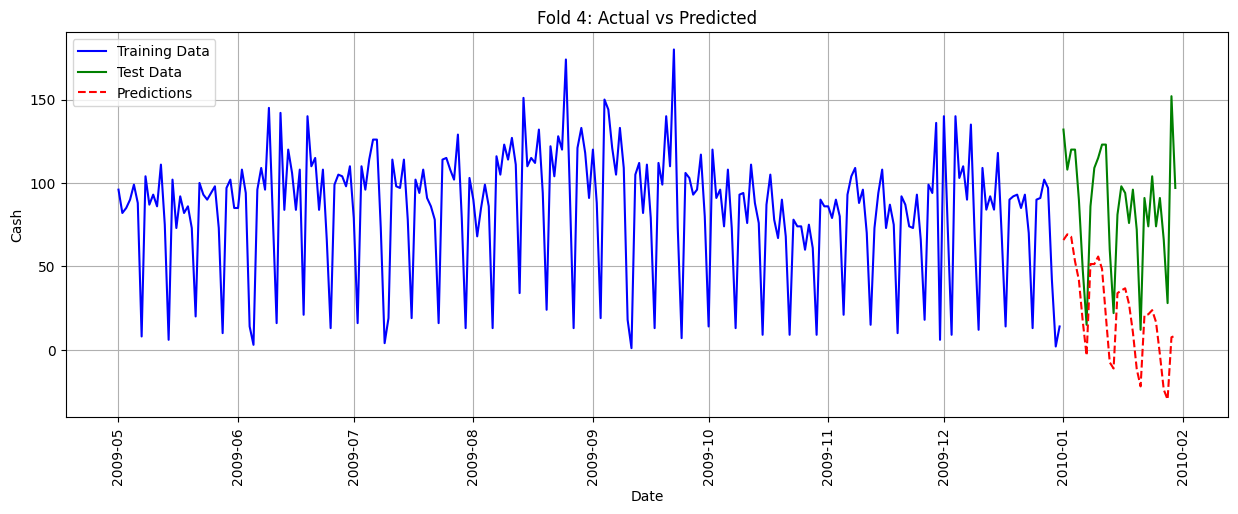



Fold 5 MAE: 20.93


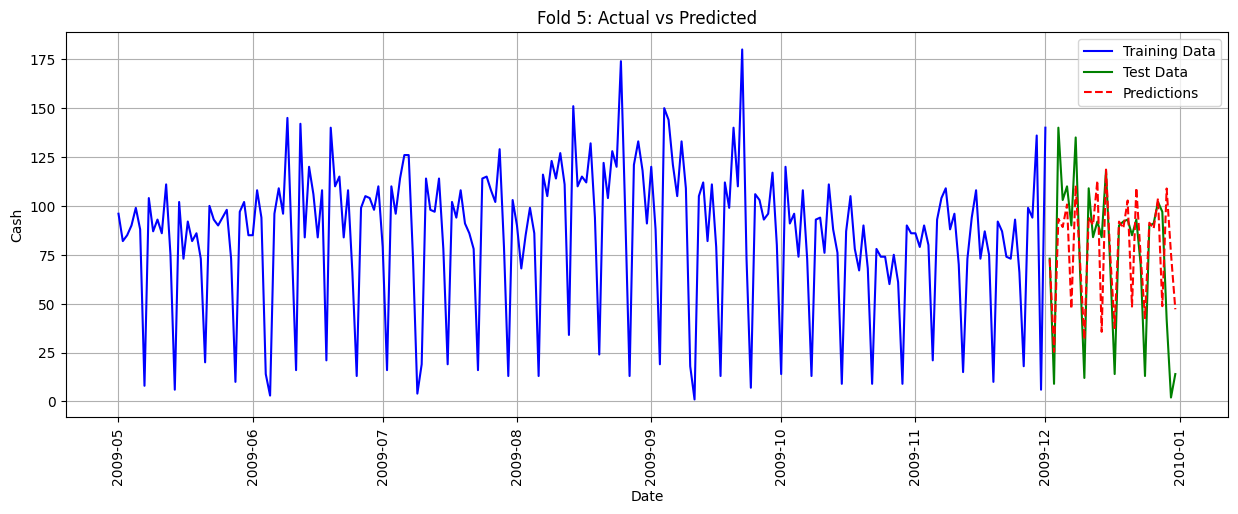



Fold 6 MAE: 16.66


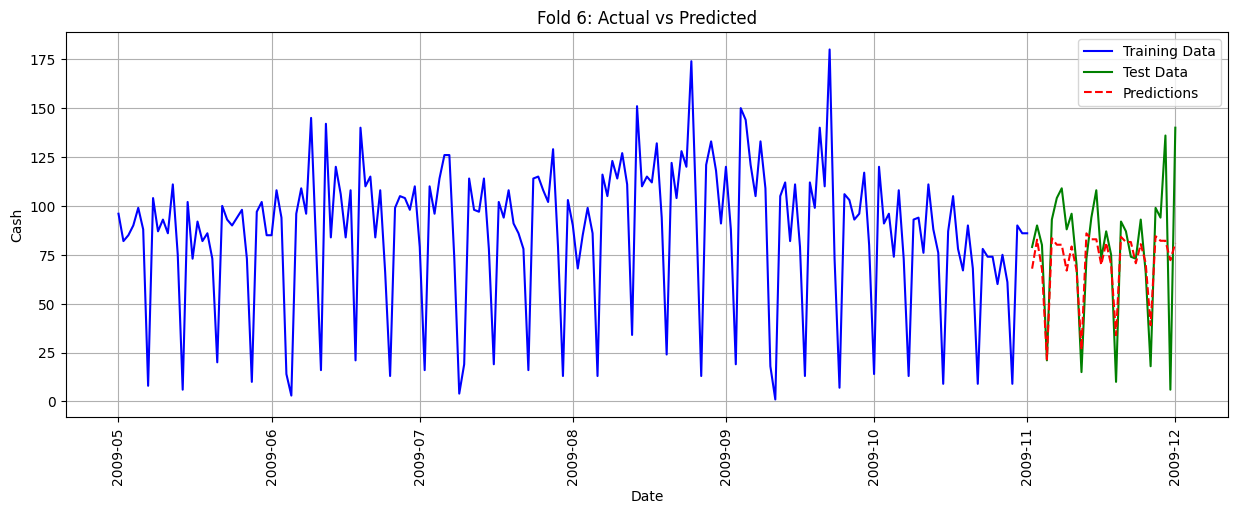



Fold 7 MAE: 23.28


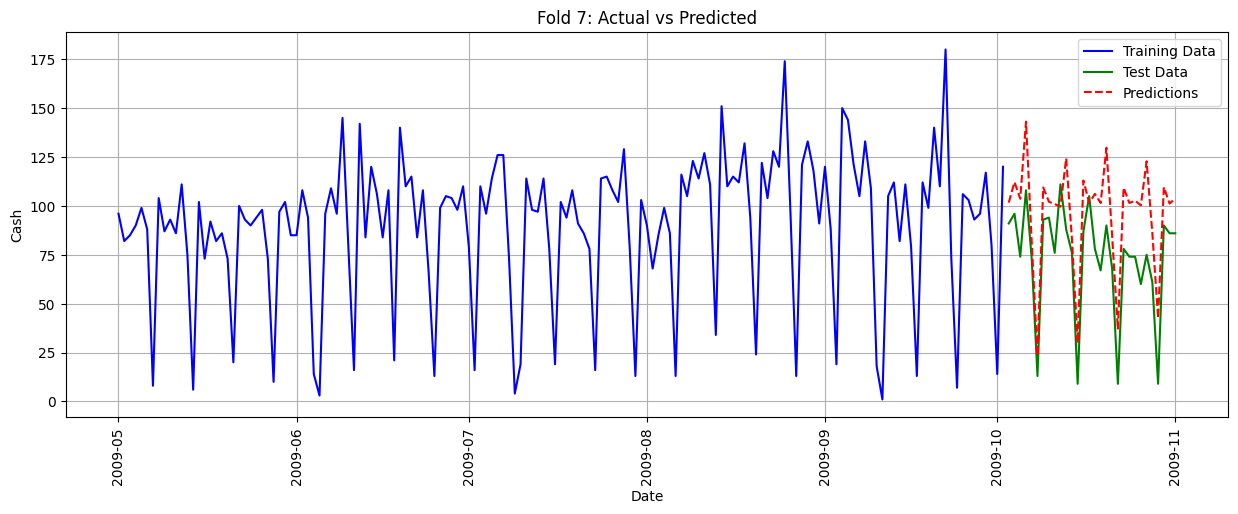



Fold 8 MAE: 19.16


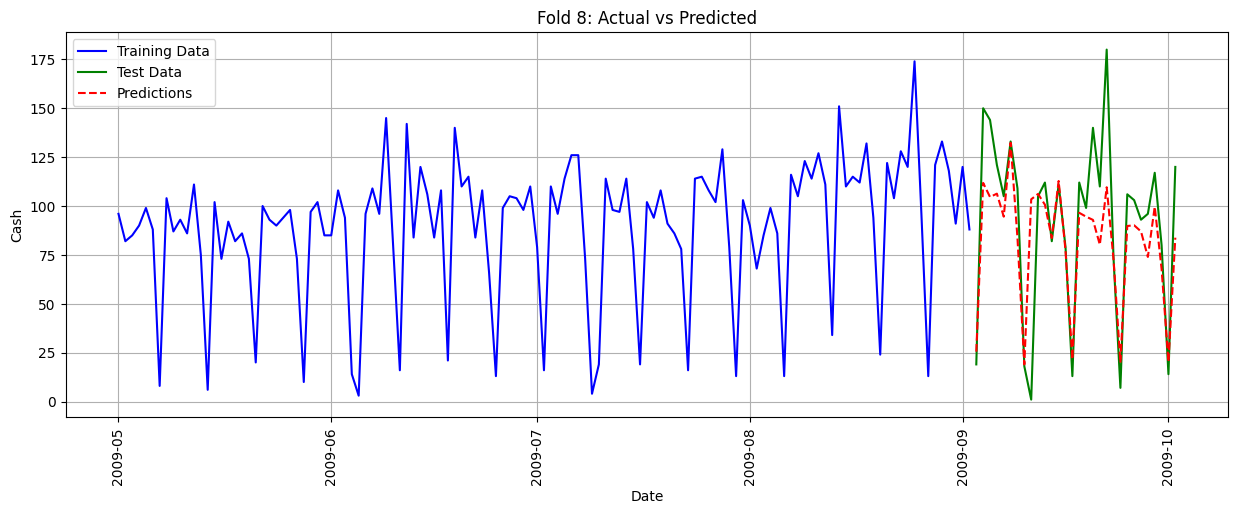



Total Average MAE: 25.13


In [96]:
from pmdarima import auto_arima

def auto_arima_forecast(train_data, test_data):
    # Fit auto ARIMA model
    model = auto_arima(train_data['Cash'], seasonal=True, m=7)  # Adjust parameters as needed
    model_fit = model.fit(train_data['Cash'])

    # Make predictions
    forecast = model_fit.predict(n_periods=len(test_data))
    return forecast

n_train_days = len(df_atm1) - 30
n_test_days = 30

dfs = split_data(df_atm1, n_train_days, n_test_days)
calculate_mae_and_plot(dfs, auto_arima_forecast)


#### Naive Model : MAE: 18.00
#### Multiple Exponentail Smooting: 23.28
#### Arima order=(1, 0, 1), seasonal_order=(0, 1, 1, 7) : 19.15
#### Arima Auto: 25.13
#### Very interseting results as with CV, the Naive Seasonal outperforms all the other 3 models.

Fold 1 MAE: 15.10


<ipython-input-97-1cfdf4f013ce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_atm2['Lag_7'] = df_atm2['Cash'].shift(7)


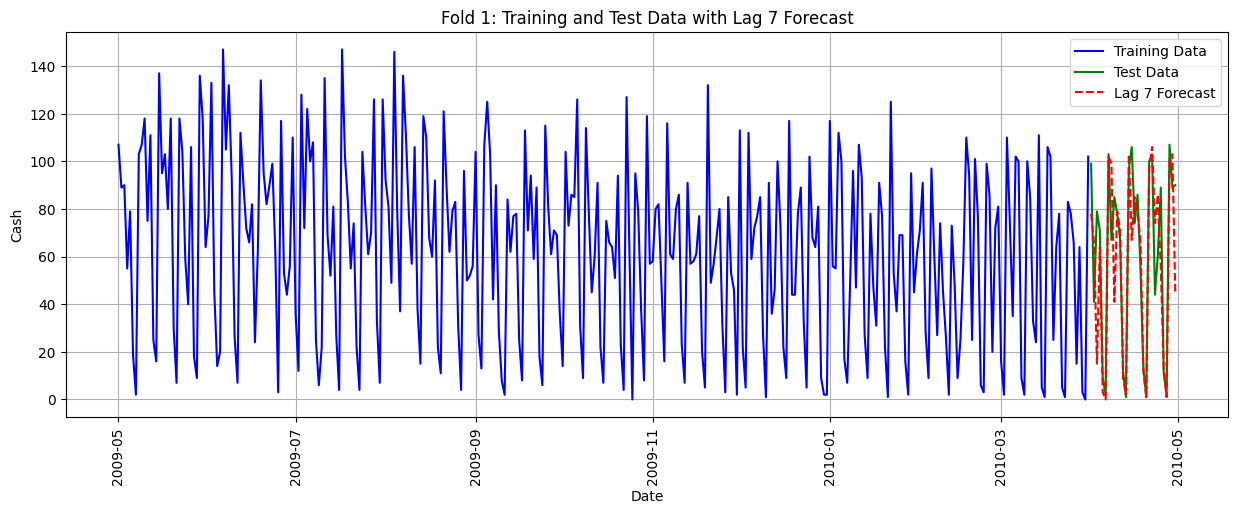



Fold 2 MAE: 16.23


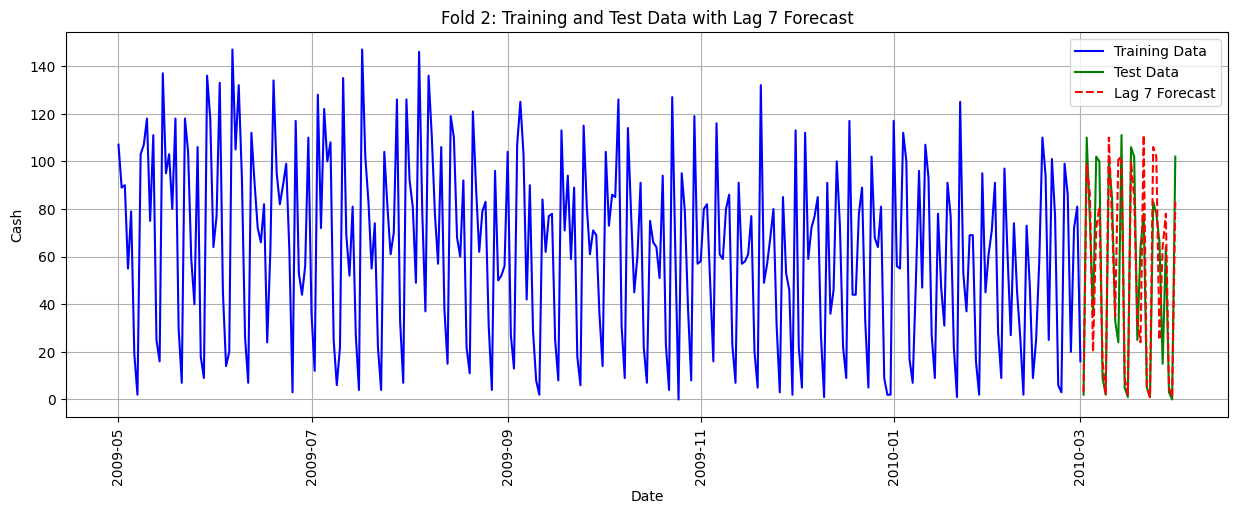



Fold 3 MAE: 25.93


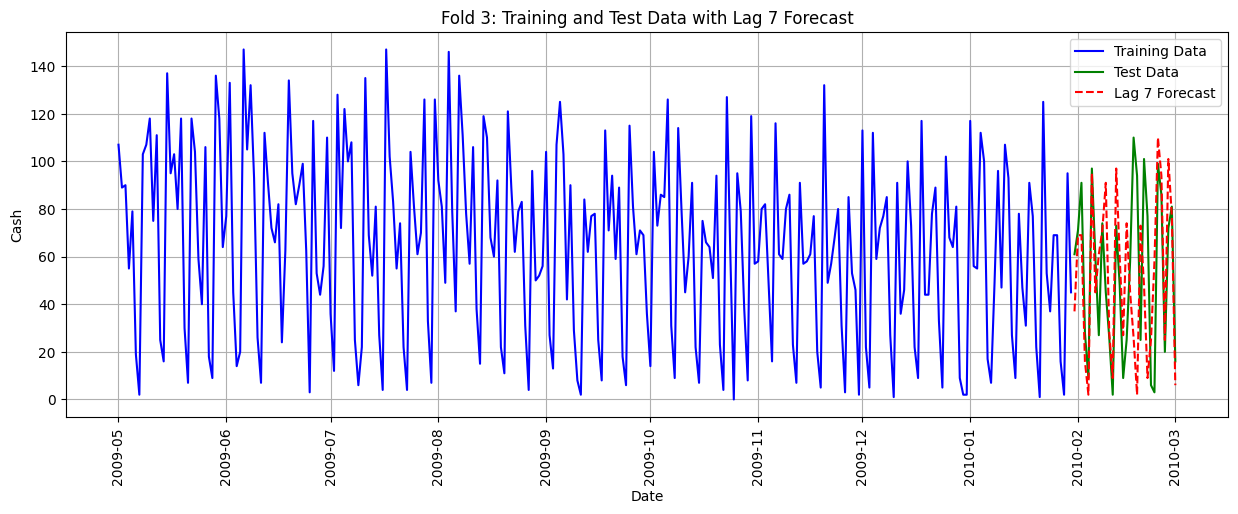



Fold 4 MAE: 19.70


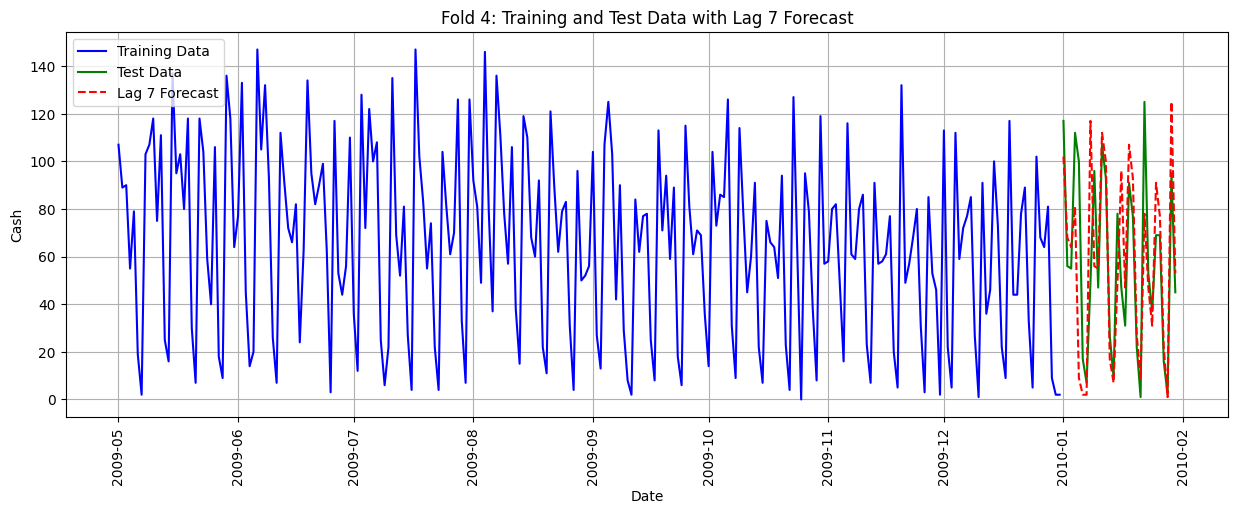



Fold 5 MAE: 18.83


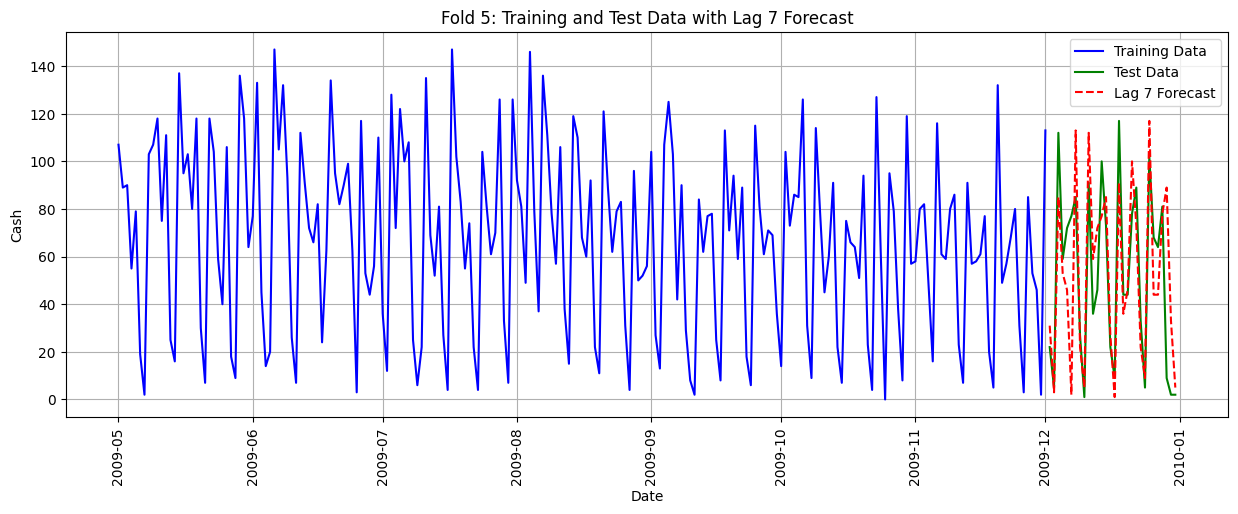



Fold 6 MAE: 12.70


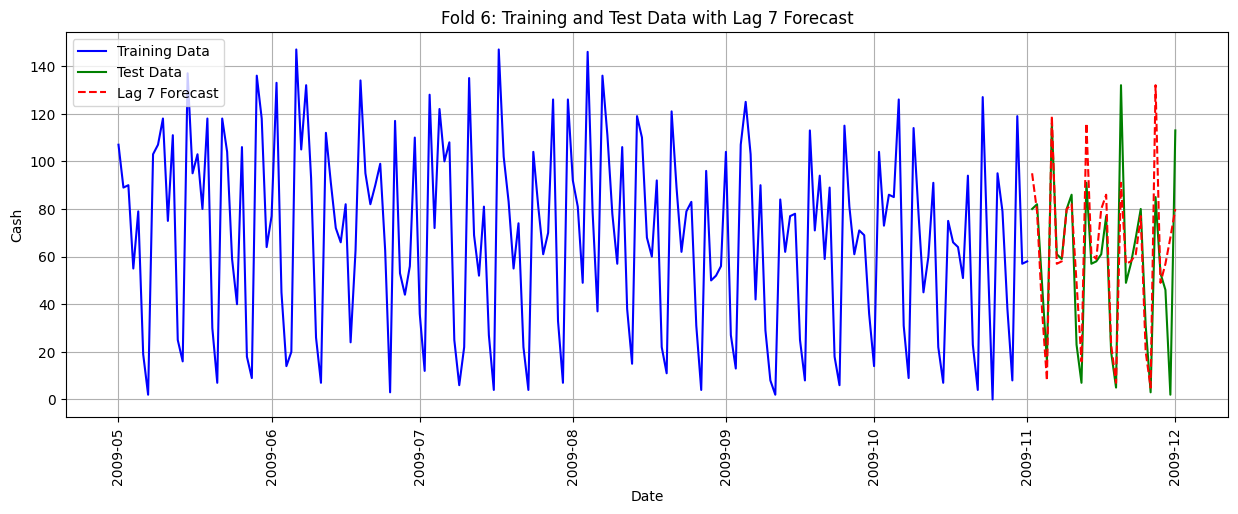



Fold 7 MAE: 19.87


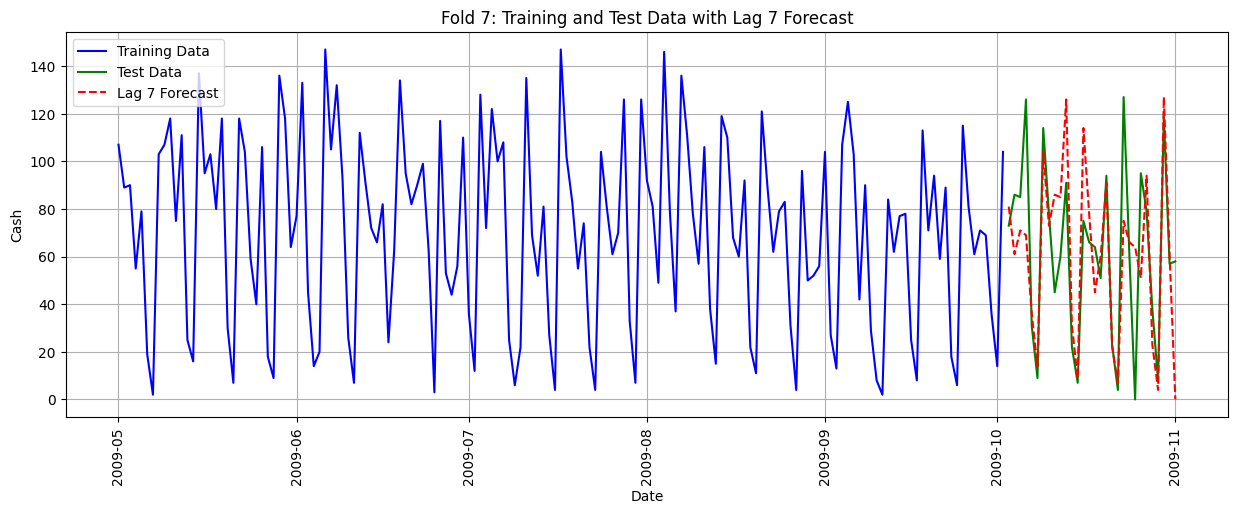



Fold 8 MAE: 24.23


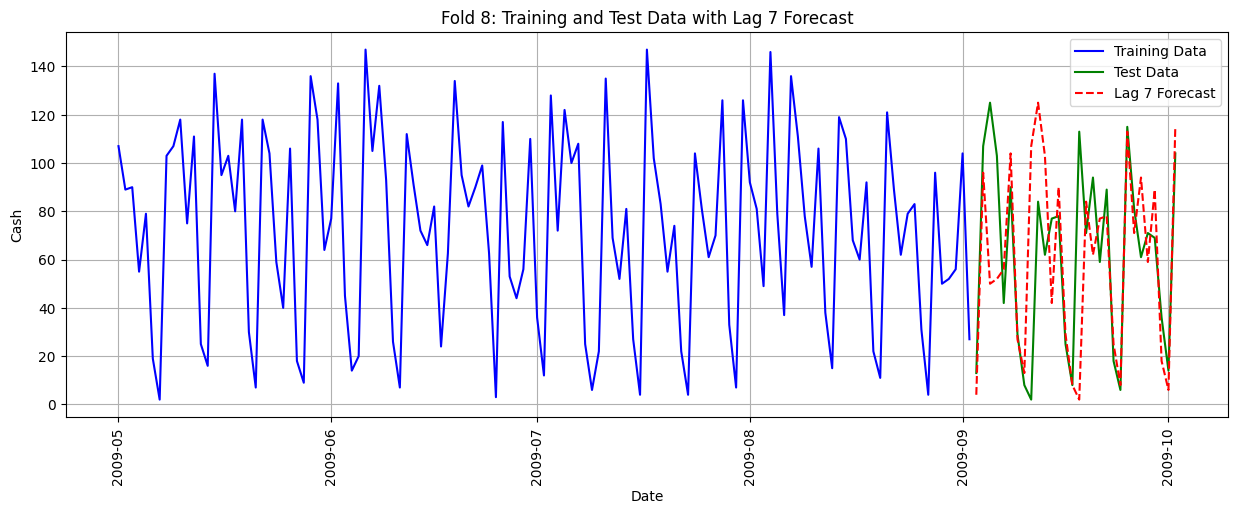



Total Average MAE: 19.08


In [97]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data stored in a DataFrame named 'data'
# Replace this with your actual data loading process
df_atm2['Lag_7'] = df_atm2['Cash'].shift(7)
# Number of days for training and testing
n_train_days = len(df_atm2) - 30  # Training data excludes the last 30 days
n_test_days = 30

# List to store the generated DataFrames
dfs = []

# Loop to create eight DataFrames
for i in range(8):
    # Extract training and testing data
    train_data = df_atm2.iloc[:n_train_days]
    test_data = df_atm2.iloc[n_train_days:n_train_days + n_test_days]

    # Append the current fold to the list of DataFrames
    dfs.append((train_data, test_data))

    # Update n_train_days for the next fold
    n_train_days -= n_test_days



# Initialize total MAE
total_mae = 0

for i, (train_data, test_data) in enumerate(dfs, 1):
    # Calculate MAE
    mae = mean_absolute_error(test_data['Cash'], test_data['Lag_7'])

    # Add current fold MAE to total MAE
    total_mae += mae

    # Output results with two decimal places
    print(f"Fold {i} MAE: {mae:.2f}")

    # Plot training data
    plt.figure(figsize=(15, 5))
    plt.plot(train_data['DATE'], train_data['Cash'], label='Training Data', color='blue')

    # Plot test data
    plt.plot(test_data['DATE'], test_data['Cash'], label='Test Data', color='green')

    # Plot lagged values (forecast) in the test data
    plt.plot(test_data['DATE'], test_data['Lag_7'], label='Lag 7 Forecast', linestyle='--', color='red')

    plt.xlabel('Date')
    plt.ylabel('Cash')
    plt.title(f'Fold {i}: Training and Test Data with Lag 7 Forecast')
    plt.legend()
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()
    print("\n" + "="*40 + "\n")

# Calculate average MAE
average_mae = total_mae / len(dfs)

# Output total average MAE with two decimal places
print(f"Total Average MAE: {average_mae:.2f}")

In [98]:
def ARIMA_eval_aic(params):
    p, d, q = params
    try:
        model = ARIMA(df_atm2['Cash'], order=(p, d, q))
        results = model.fit()
        return results.aic
    except:
        return None

# Define the ranges for p, d, and q
p_range = range(0, 3)
d_range = range(0, 3)
q_range = range(0, 3)

# Generate all possible combinations of p, d, and q
param_grid = itertools.product(p_range, d_range, q_range)

# Filter out combinations where p, d, and q are not all greater than 0
param_grid_filtered = [(p, d, q) for (p, d, q) in param_grid if (p > 0 or d > 0 or q > 0)]

# Calculate AIC for each combination
aic_values = {}
for params in param_grid_filtered:
    aic_values[params] = ARIMA_eval_aic(params)

# Print all AIC values
for params, aic in aic_values.items():
    print(f"({params}): AIC = {aic}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

((0, 0, 1)): AIC = 3710.704109217184
((0, 0, 2)): AIC = 3668.830946493495
((0, 1, 0)): AIC = 3941.6662703451066
((0, 1, 1)): AIC = 3698.5460840868386
((0, 1, 2)): AIC = 3700.470802060596
((0, 2, 0)): AIC = 4280.930100363547
((0, 2, 1)): AIC = 3939.7404081252216
((0, 2, 2)): AIC = 3697.5377978325005
((1, 0, 0)): AIC = 3711.1423098847863
((1, 0, 1)): AIC = 3695.132986060473
((1, 0, 2)): AIC = 3670.7870844570834
((1, 1, 0)): AIC = 3907.4255910695365
((1, 1, 1)): AIC = 3700.530975843306
((1, 1, 2)): AIC = 3685.875727778905
((1, 2, 0)): AIC = 4198.170439067251
((1, 2, 1)): AIC = 3906.120908019532
((1, 2, 2)): AIC = 3943.0660745198093
((2, 0, 0)): AIC = 3663.9710916921827
((2, 0, 1)): AIC = 3662.0054019203526
((2, 0, 2)): AIC = 3559.6532258343236
((2, 1, 0)): AIC = 3767.0040032245934
((2, 1, 1)): AIC = 3639.352695925538
((2, 1, 2)): AIC = 3640.1940164143684
((2, 2, 0)): AIC = 4018.961338051898
((2, 2, 1)): AIC = 3766.980456694782
((2, 2, 2)): AIC = 3644.845170696417


Fold 1 MAE: 9.36


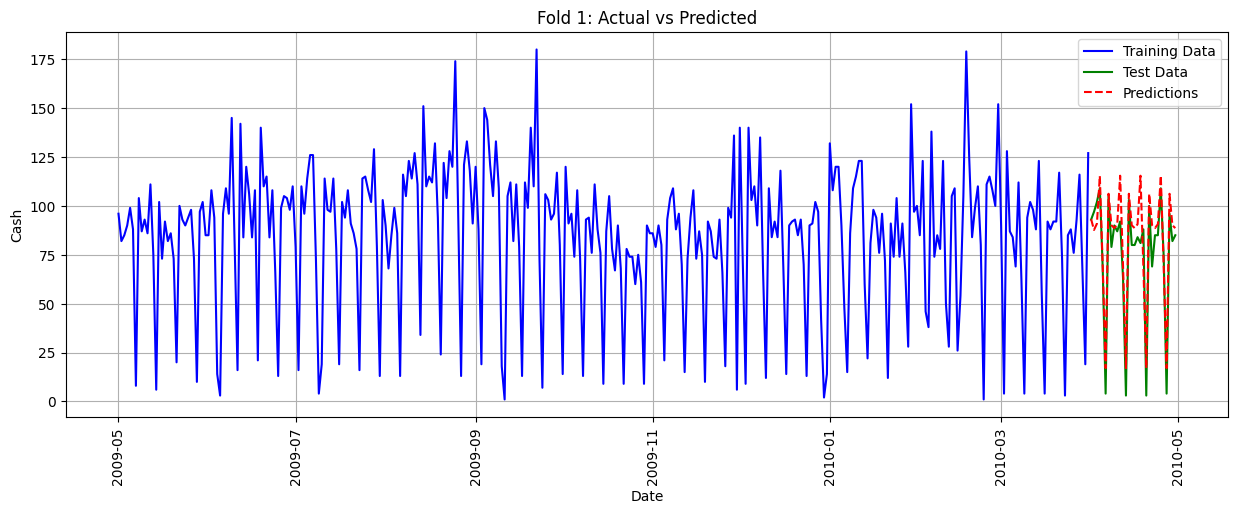



Fold 2 MAE: 32.64


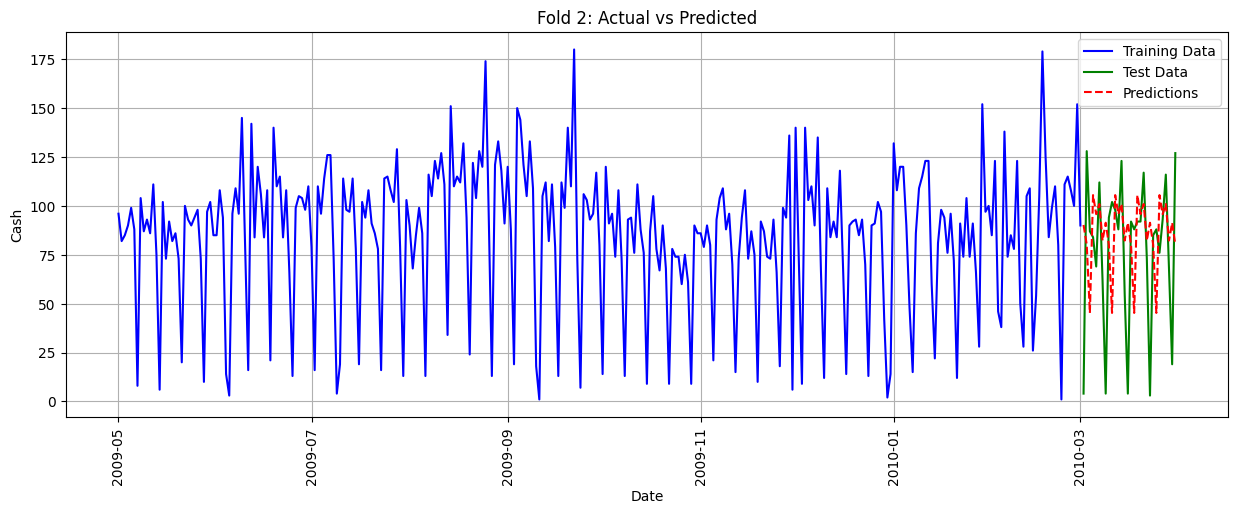



Fold 3 MAE: 29.94


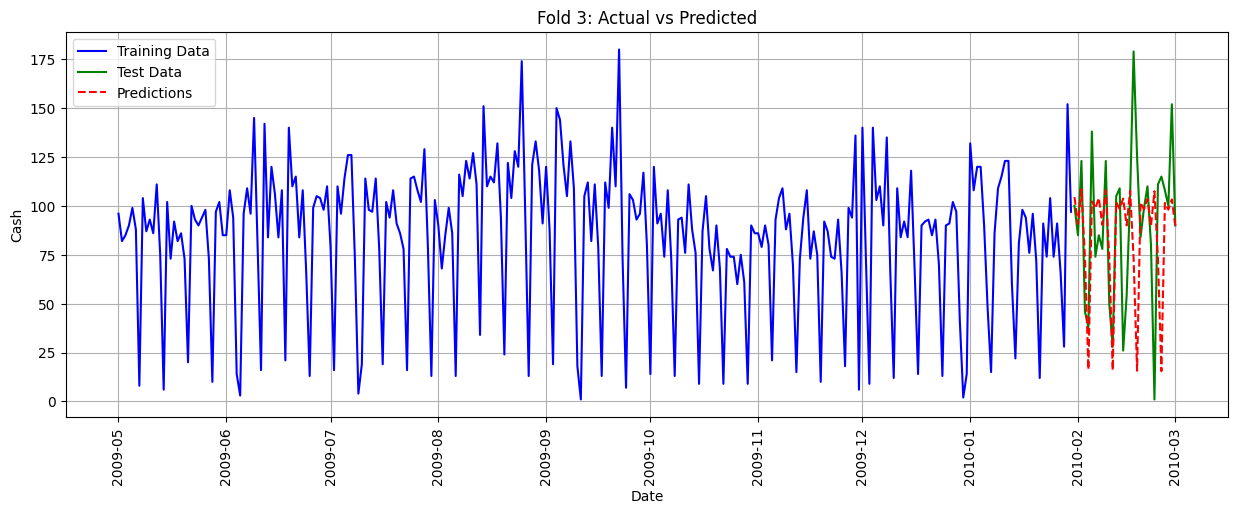

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fold 4 MAE: 16.89


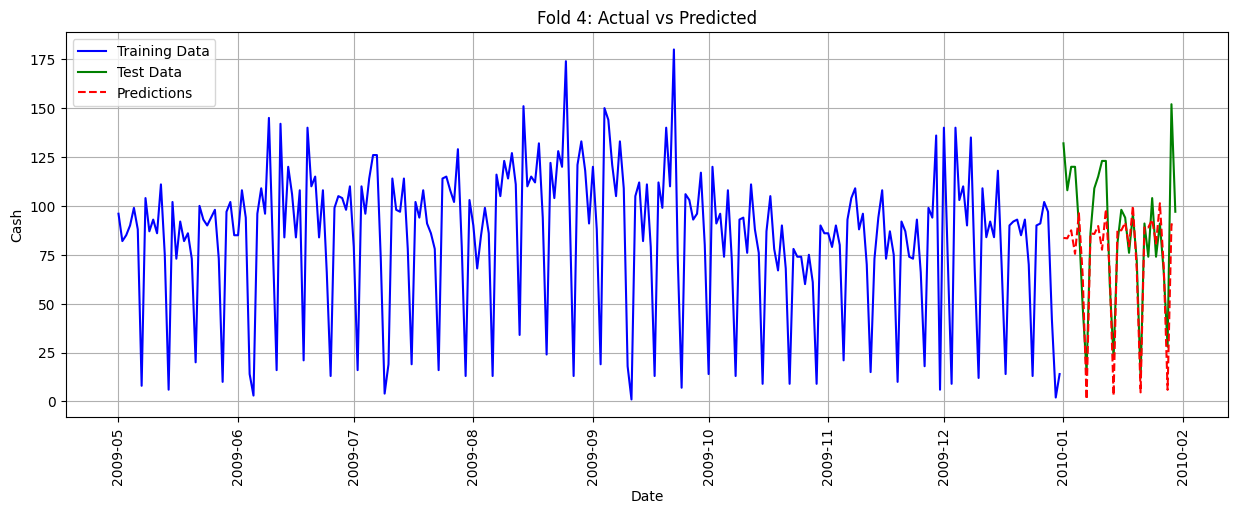



Fold 5 MAE: 12.59


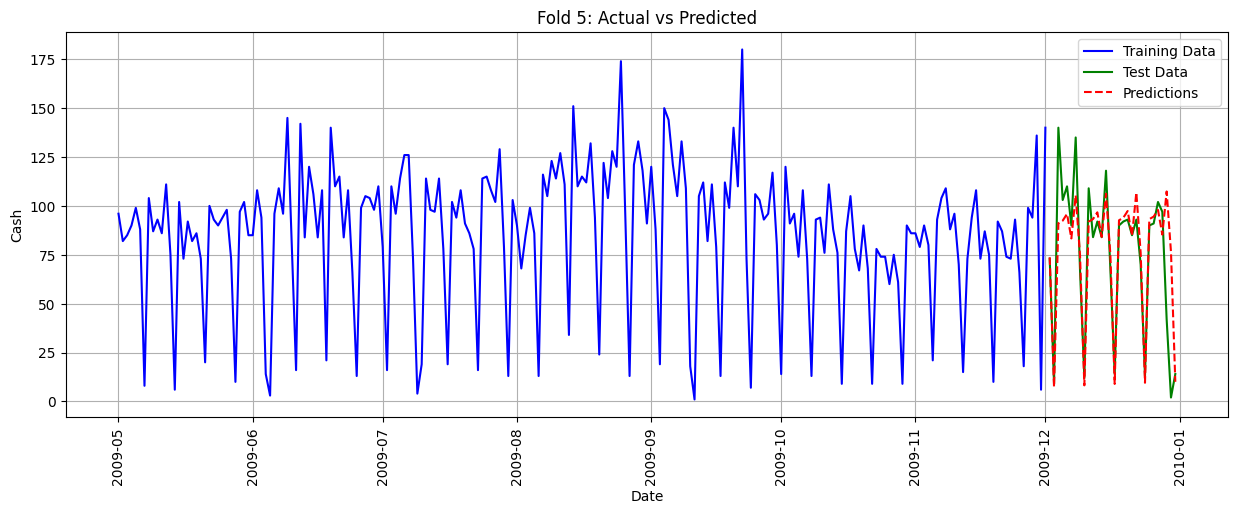



Fold 6 MAE: 14.03


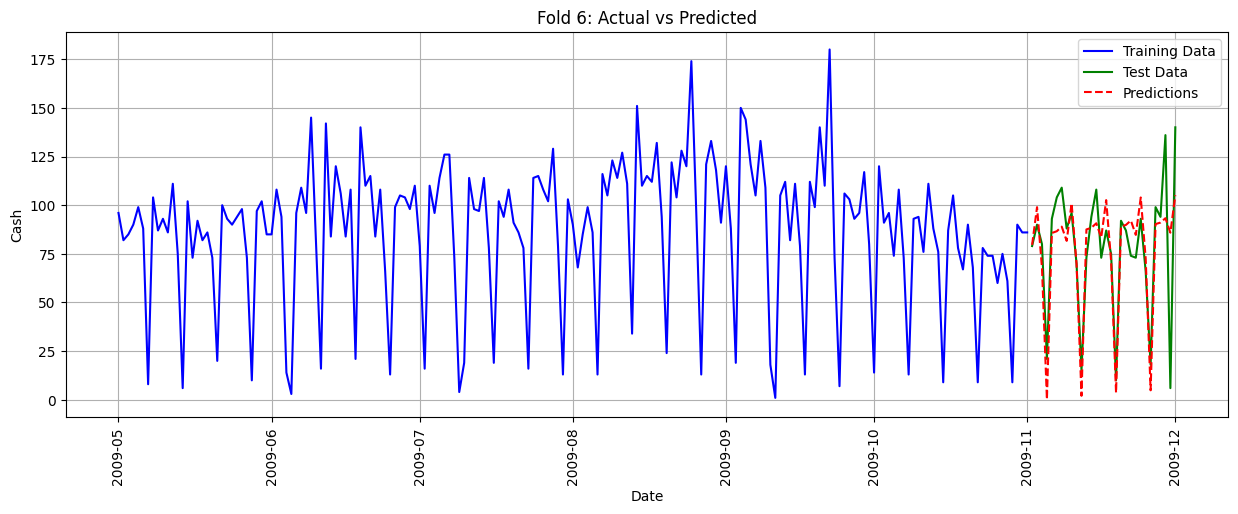



Fold 7 MAE: 19.08


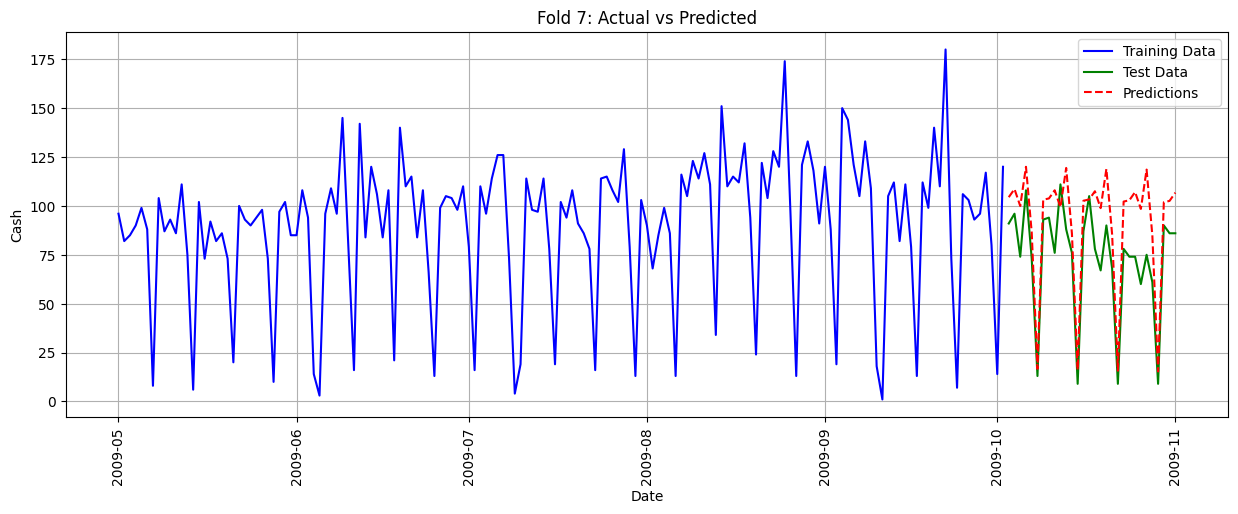

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fold 8 MAE: 18.67


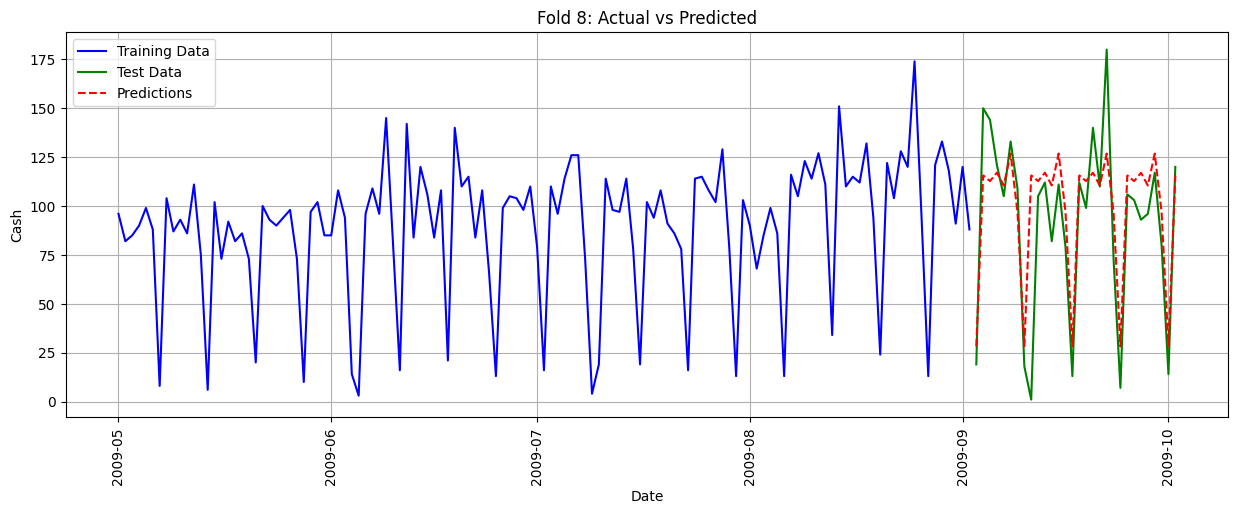



Total Average MAE: 19.15


In [99]:
def arima_forecast(train_data, test_data):
    # Fit ARIMA model
    model = ARIMA(train_data['Cash'], order=(1, 0, 1), seasonal_order=(0, 1, 1, 7))  # You may need to adjust the order
    model_fit = model.fit()

    # Make predictions
    forecast = model_fit.forecast(steps=len(test_data))

    return forecast

n_train_days = len(df_atm2) - 30
n_test_days = 30

dfs = split_data(df_atm1, n_train_days, n_test_days)
calculate_mae_and_plot(dfs, arima_forecast)


In [100]:
from pmdarima import auto_arima

def auto_arima_forecast(train_data, test_data):
    # Fit auto ARIMA model
    model = auto_arima(train_data['Cash'], seasonal=True, m=7)  # Adjust parameters as needed
    model_fit = model.fit(train_data['Cash'])

    # Make predictions
    forecast = model_fit.predict(n_periods=len(test_data))
    return forecast

n_train_days = len(df_atm1) - 30
n_test_days = 30

dfs = split_data(df_atm1, n_train_days, n_test_days)
calculate_mae_and_plot(dfs, auto_arima_forecast)


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have your data stored in a DataFrame named 'df_atm1'
# Replace this with your actual data loading process

n_train_days = len(df_atm1) - 30  # Training data excludes the last 30 days
n_test_days = 30

# Split data into training and testing sets
dfs = split_data(df_atm1, n_train_days, n_test_days)

# Initialize total MAE
total_mae = 0

# Loop over each fold
for i, (train_data, test_data) in enumerate(dfs, 1):
    # Apply ARIMA forecasting
    predictions = arima_forecast(train_data, test_data, order=(1, 0, 1))
    print(predictions)
    # Calculate MAE
    mae = mean_absolute_error(test_data['Cash'], predictions)

    # Add current fold MAE to total MAE
    total_mae += mae

    # Output results with two decimal places
    print(f"Fold {i} MAE: {mae:.2f}")

    # Plot training data
    plt.figure(figsize=(15, 5))
    plt.plot(train_data.index, train_data['Cash'], label='Training Data', color='blue')

    # Plot test data
    plt.plot(test_data.index, test_data['Cash'], label='Test Data', color='green')

    # Plot ARIMA forecast
    plt.plot(test_data.index, predictions, label='ARIMA Forecast', linestyle='--', color='red')

    plt.xlabel('Date')
    plt.ylabel('Cash')
    plt.title(f'Fold {i}: Training and Test Data with ARIMA Forecast')
    plt.legend



In [ ]:
results.forecast(steps=30)

In [ ]:
residuals = actual_data - fc_atm4_em

In [ ]:
def calculate_and_plot_mae(dfs, forecast_function):
    """
    Calculate MAE for each fold and plot actual vs predicted values.

    Args:
    - dfs: List of tuples, each containing training and testing DataFrames
    - forecast_function: Function to generate predictions

    Returns:
    - Total average MAE
    """
    total_mae = 0

    for i, (train_data, test_data) in enumerate(dfs, 1):
        # Make predictions using the provided forecast function
        predictions = forecast_function(train_data, test_data)

        # Calculate MAE
        mae = calculate_mae(predictions, test_data['Cash'])
        total_mae += mae
        print(f"Fold {i} MAE: {mae:.2f}")

        # Plot actual vs predicted values
        plot_actual_vs_predicted(train_data, test_data, predictions, i)
        print("\n" + "="*40 + "\n")

    # Calculate average MAE
    average_mae = total_mae / len(dfs)

    # Output total average MAE with two decimal places
    print(f"Total Average MAE: {average_mae:.2f}")

calculate_and_plot_mae(dfs, seasonal_naive_forecast)

In [ ]:
# Calculate MAE for each fold
for i, (train_data, test_data) in enumerate(dfs, 1):
    # Make predictions using the seasonal naive model
    predictions = seasonal_naive_forecast(train_data, test_data)

    # Print lengths of test data and predictions
    print(f"Fold {i} - Test Data Length: {len(test_data)}, Predictions Length: {len(predictions)}")

    # Calculate MAE
    mae = mean_absolute_error(test_data['Cash'], predictions)

    # Add current fold MAE to total MAE
    total_mae += mae

    # Output results with two decimal places
    print(f"Fold {i} MAE: {mae:.2f}")

    # Create facet grid plot
    g = sns.FacetGrid(test_data, height=5, aspect=2)
    g.map_dataframe(lambda data, color: plt.plot(data['DATE'], data['Cash'], color=color))
    g.map_dataframe(lambda data, color: plt.plot(data['DATE'], predictions, linestyle='--', color=color))
    g.set_axis_labels('Date', 'Cash')
    g.add_legend(title='Data')
    g.fig.suptitle(f'Fold {i}: Actual vs Predicted', fontsize=16)
    plt.xticks(rotation=90)  # Rotate the date labels by 90 degrees
    plt.grid(True)
    plt.show()
    print("\n" + "="*40 + "\n")

# Calculate average MAE
average_mae = total_mae / len(dfs)

# Output total average MAE with two decimal places
print(f"Total Average MAE: {average_mae:.2f}")


In [ ]:
import pandas as pd

# Assuming you have your data stored in a DataFrame named 'data'
# Replace this with your actual data loading process

# Generate sample data
data = pd.DataFrame({
    'Day': range(1, 365),
    'Cash': range(1, 365)
})

# Number of days for training and testing
n_train_days = len(data) - 30  # Training data excludes the last 30 days
n_test_days = 30

# List to store the generated DataFrames
dfs = []

# Loop to create six DataFrames
for i in range(6):
    # Extract training and testing data
    train_data = data.iloc[:n_train_days]
    test_data = data.iloc[n_train_days:n_train_days + n_test_days]

    # Append the current fold to the list of DataFrames
    dfs.append((train_data, test_data))

    # Update n_train_days for the next fold
    n_train_days -= n_test_days

# Displaying the six DataFrames
for i, (train_data, test_data) in enumerate(dfs, 1):
    print(f"DataFrame {i} (Training Data):")
    print(train_data)
    print(f"\nDataFrame {i} (Testing Data):")
    print(test_data)
    print()


In [ ]:
# 2. Moving Average
class MovingAverage(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=7):
        self.window_size = window_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.rolling(window=self.window_size).mean()

# 3. STL (Seasonal and Trend decomposition using Loess)
def stl_forecast(train_data):
    stl_decomp = STL(train_data, seasonal=13).fit()
    return stl_decomp.forecast(steps=365)

# 4. Exponential Smoothing
def exponential_smoothing_forecast(train_data):
    model = ExponentialSmoothing(train_data)
    model_fit = model.fit()
    return model_fit.forecast(365)

# 5. ARIMA
def arima_forecast(train_data):
    model = ARIMA(train_data, order=(5,1,0))
    model_fit = model.fit()
    return model_fit.forecast(steps=365)[0]

# Define Pipelines
naive_seasonality_pipeline = naive_seasonality_forecast
moving_average_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('moving_avg', MovingAverage(window_size=7))
])
stl_pipeline = stl_forecast
exponential_smoothing_pipeline = exponential_smoothing_forecast
arima_pipeline = arima_forecast

# Usage:
# Assuming 'train_data' is your DataFrame containing one year of daily cash out for an ATM
# Use each pipeline to forecast the next year's cash out
# For example:
# naive_forecast = naive_seasonality_pipeline(train_data)
# moving_avg_forecast = moving_average_pipeline.fit_transform(train_data)
# stl_forecast = stl_pipeline(train_data)
# exponential_smoothing_forecast = exponential_smoothing_pipeline(train_data)
# arima_forecast = arima_pipeline(train_data)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Define Time Series Cross-Validation
min_train_months = 5  # Minimum number of months for training
max_train_months = 11  # Maximum number of months for training
n_splits = max_train_months - min_train_months + 1
tscv = TimeSeriesSplit(n_splits=n_splits)

# Train and Validate each Model
for train_index, val_index in tscv.split(df_atm1):
    # Extract Training and Validation Data
    train_data = df_atm.iloc[train_index]
    val_data = df_atm.iloc[val_index]

    # Train and Validate each Model
    naive_forecast = naive_seasonality_pipeline(train_data)
    # moving_avg_forecast = moving_average_pipeline.fit(train_data).transform(val_data)
    # stl_forecast = stl_pipeline(train_data)
    # exponential_smoothing_forecast = exponential_smoothing_pipeline(train_data)
    # arima_forecast = arima_pipeline(train_data)

    # Evaluate Models and Perform Cross-Validation
    # You can evaluate the performance of each model here using appropriate metrics
    # For simplicity, you can print or store the forecasts for further analysis
    print("Naive Forecast:", naive_forecast)
    # print("Moving Average Forecast:", moving_avg_forecast)
    # print("STL Forecast:", stl_forecast)
    # print("Exponential Smoothing Forecast:", exponential_smoothing_forecast)
    # print("ARIMA Forecast:", arima_forecast)


In [ ]:
# Visualize the decomposition
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(df_atm['Cash'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

## Part B
Consists of a simple dataset of residential power usage for January 1998 until December 2013.  Your assignment is to model these data and a monthly forecast for 2014.  The data is given in a single file.  The variable ‘KWH’ is power consumption in Kilowatt hours, the rest is straight forward.    Add this to your existing files above.

## Part C
Consists of two data sets.  These are simple 2 columns sets, however they have different time stamps.  Your optional assignment is to time-base sequence the data and aggregate based on hour (example of what this looks like, follows).  Note for multiple recordings within an hour, take the mean.  Then to determine if the data is stationary and can it be forecast.  If so, provide a week forward forecast and present results via Rpubs and .rmd and the forecast in an Excel readable file.   

In [107]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Read data
water1 = df_wp1
water2 = df_wp2

# Rename columns
water1.columns = ["DateTime", "WaterFlow"]
water2.columns = ["DateTime", "WaterFlow"]

# Combine readings for pipeline 1 to hourly
water1["DateTime"] = pd.to_datetime(water1["DateTime"])
water2["DateTime"] = pd.to_datetime(water2["DateTime"])
water1_hourly = water1.resample("H", on="DateTime").mean().reset_index()

# Join datasets
water_df = pd.merge(water1_hourly, water2, on="DateTime", how="outer", suffixes=("_1", "_2"))
water_df["WaterFlow_1"] = water_df["WaterFlow_1"].fillna(0)
water_df["WaterFlow"] = water_df["WaterFlow_1"] + water_df["WaterFlow_2"]
water_ts = pd.Series(water_df["WaterFlow"].values, index=water_df["DateTime"])
water_ts.index.freq = "H"

# Plot timeseries
fig = go.Figure()
fig.add_trace(go.Scatter(x=water_ts.index, y=water_ts.values, mode="lines", name="WaterFlow"))
fig.update_layout(title="Two Pipelines Hourly Water Flow",
                  xaxis_title="Day",
                  yaxis_title="Total Waterflow",
                  showlegend=False)
fig.show()


In [113]:
from scipy.stats import boxcox
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Try different lambda values to find a suitable one
lambda_values = np.linspace(-2, 2, 100)
best_lambda = None
best_transform = None
best_loglikelihood = float("-inf")

for lmbda in lambda_values:
    # Transform the data using the current lambda value
    water_trans = boxcox(water_ts, lmbda=lmbda)

    # Calculate the log-likelihood
    loglikelihood = boxcox_llf(water_ts, lmbda)

    # Check if the current log-likelihood is better than the best one so far
    if loglikelihood > best_loglikelihood:
        best_lambda = lmbda
        best_transform = water_trans
        best_loglikelihood = loglikelihood

# Check if a suitable lambda value was found
if best_lambda is None:
    raise ValueError("Box-Cox transformation failed. Try different initial values.")

# Plot differenced transformed series
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=best_transform.index, y=best_transform.diff().values, mode="lines", name="Transformed WaterFlow Differenced"),
              row=1, col=1)


NameError: name 'boxcox_llf' is not defined

In [ ]:

# Fit ARIMA(1,1,1) model
d = ndiffs(water_trans)
water_fit = ARIMA(water_trans, order=(1, d, 1)).fit()

# Check residuals
residuals = water_fit.resid
acf_plot = plot_acf(residuals, lags=40, zero=False)
pacf_plot = plot_pacf(residuals, lags=40, zero=False)

# Plot residuals
fig = make_subplots(rows=2, cols=1)
fig.add_trace(acf_plot, row=1, col=1)
fig.add_trace(pacf_plot, row=2, col=1)
fig.update_layout(title="WaterFlow Residuals for ARIMA(1,1,1)")
fig.show()

# Forecast using ARIMA(1,1,1)
forecast = water_fit.forecast(steps=168)

# Create forecast dataframe
forecast_df = pd.DataFrame({"DateTime": pd.date_range(water_df["DateTime"].max(), periods=168, freq="H"),
                            "WaterFlow": forecast})

# Write forecast to CSV
forecast_df.to_csv("/Users/hovig/Downloads/output_data624_project1_partC.csv", index=False)
